Total number of points:  200


<IPython.core.display.Javascript object>


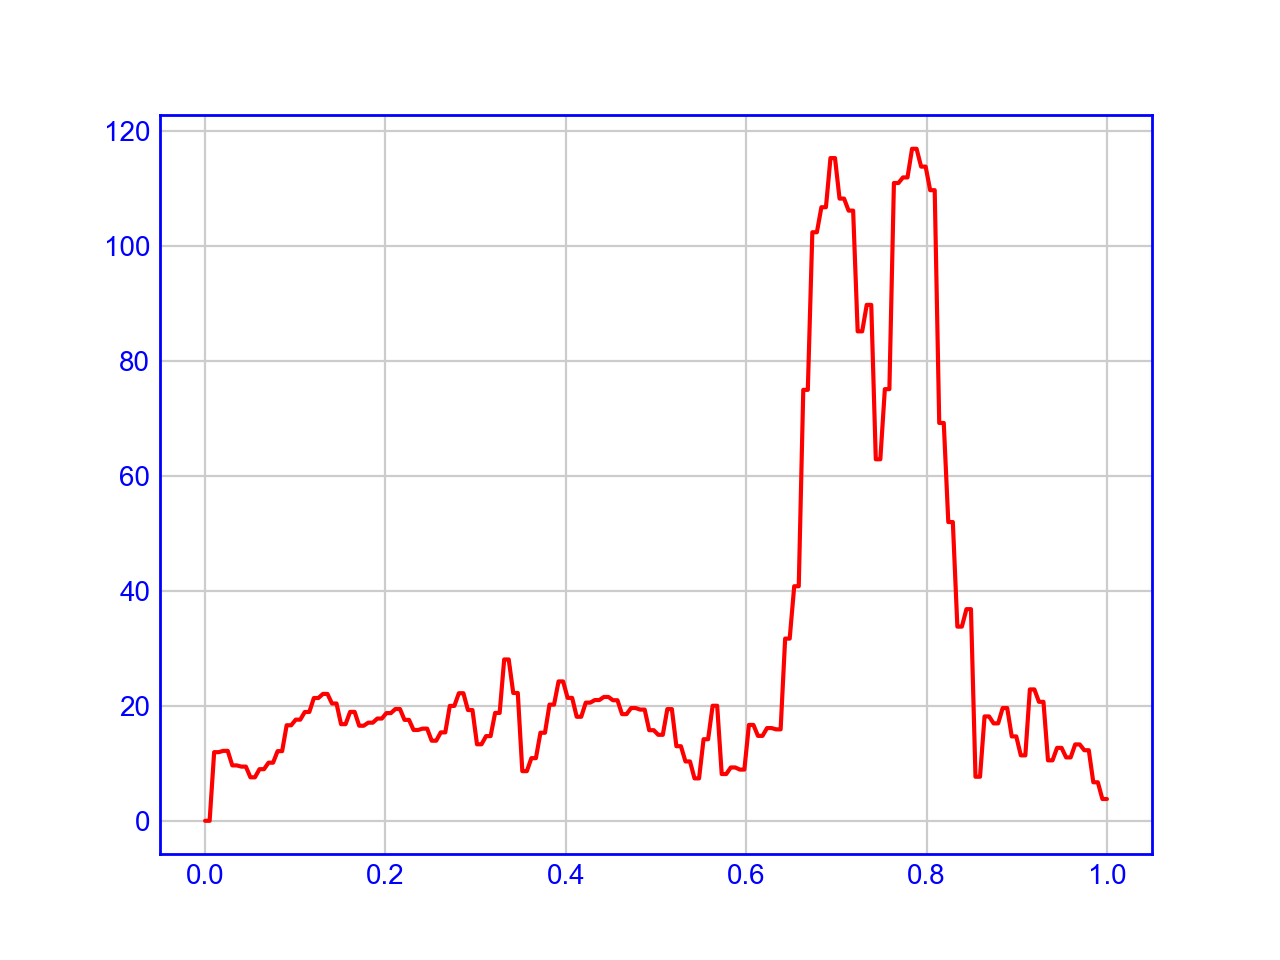

Using the solver:  SLSQP


In [92]:
# coding: utf-8
%matplotlib notebook

import sys, math
import numpy as np
import scipy
import diy
from matplotlib import pyplot as plt

from scipy import linalg, matrix
from scipy.interpolate import LSQUnivariateSpline, UnivariateSpline, interp1d, Rbf
from scipy.optimize import minimize

from makruth_solver import basis, getControlPoints, decode, Error, L2LinfErrors
from makruth_solver import knotInsert, knotRefine, deCasteljau

plt.style.use(['seaborn-whitegrid'])
# plt.style.use(['ggplot'])
# plt.style.use(['classic'])
params = {"ytick.color" : "b",
          "xtick.color" : "b",
          "axes.labelcolor" : "b",
          "axes.edgecolor" : "b"}
plt.rcParams.update(params)

# --- set problem input parameters here ---
nSubDomains    = 2
degree         = 3
nControlPoints = (4*degree + 1) #minimum number of control points
useDecodedResidual = False
overlapData    = 10
overlapCP      = 0
problem        = 2
scale          = 1
# ------------------------------------------
# Solver parameters
solverscheme   = 'SLSQP' # [SLSQP, COBYLA]
useAdditiveSchwartz = True
useDerivativeConstraints = -1
enforceBounds = True
disableAdaptivity = True

subdomainSolverSchemes = ['LCLSQ', 'SLSQP', 'L-BFGS-B', 'CG']
subdomainSolver = subdomainSolverSchemes[1]

maxAbsErr       = 1e-5
maxRelErr       = 1e-8

solverMaxIter   = 50
globalTolerance = 1e-13

# AdaptiveStrategy = 'extend'
AdaptiveStrategy = 'reset'

##----------------------
## Problematic settings
# problem        = 0
# nSubDomains    = 4
# degree         = 3
# nControlPoints = (3*degree + 1) #minimum number of control points
# subdomainSolver = subdomainSolverSchemes[0]
##----------------------

if problem == 0:
    Dmin           = -4.
    Dmax           = 4.
    nPoints        = 101
    x = np.linspace(Dmin, Dmax, nPoints)
    y = scale * np.sinc(x)
    # y = scale * np.sin(math.pi * x/4)
elif problem == 1:
    y = np.fromfile("s3d.raw", dtype=np.float64) #
    print('Real data shape: ', y.shape)
    nPoints = y.shape[0]
    Dmin           = 0
    Dmax           = 1.
    x = np.linspace(Dmin, Dmax, nPoints)
else:
    Y = np.fromfile("nek5000.raw", dtype=np.float64) #
    Y = Y.reshape(200,200)
    y = Y[100,:] # Y[:,150] # Y[110,:]
    Dmin           = 0
    Dmax           = 1.
    nPoints = y.shape[0]
    x = np.linspace(Dmin, Dmax, nPoints)

    
# if nPoints % nSubDomains > 0:
#     print ( "[ERROR]: The total number of points do not divide equally with subdomains" )
#     sys.exit(1)

ymin = y.min()
ymax = y.max()
yRange = ymax-ymin
yRange = 1
print('Total number of points: ', nPoints)
mpl_fig = plt.figure()
plt.plot(x, y, 'r-', ms=2)
# plt.plot(x, y[:,150], 'g-', ms=2)
# plt.plot(x, y[110,:], 'b-', ms=2)

# nPoints = len(x)
# Dmin = min(x)
# Dmax = max(x)

print('Using the solver: ', subdomainSolver)


In [93]:
# Initialize DIY
w = diy.mpi.MPIComm()           # world

#------------------------------------
EPS    = 1e-14
basis  = lambda u,p,T: ((T[:-1]<=u) * (u<=T[1:])).astype(np.float) if p==0 else ((u - T[:-p]) /(T[p:]  -T[:-p]+EPS))[:-1] * basis(u,p-1,T)[:-1] + ((T[p+1:] - u)/(T[p+1:]-T[1:-p]+EPS))     * basis(u,p-1,T)[1:]

def WeightedConstrainedLSQ_PT(idom, Nall, Wall, ysloc, U, t, degree, nSubDomains, constraintsAll=None, useDerivatives=0, solver='SLSQP'):

    if constraintsAll is not None:
        constraints = np.array(constraintsAll['P'])
        knotsAll = np.array(constraintsAll['T'])
        weightsAll = np.array(constraintsAll['W'])
        # print ('Constraints for Subdom = ', idom, ' is = ', constraints)
    else:
        print ('Constraints are all null. Solving unconstrained.')

    def ComputeL2Error0(P, N, W, ysl, U, t, degree):
        E = np.sum(Error(P, W, ysl, U, t, degree)**2)/len(P)
        return math.sqrt(E)

    def ComputeL2Error(P, N, W, ysl, U, t, degree):
        RN = (N*W)/(np.sum(N*W, axis=1)[:,np.newaxis])
        E = (RN.dot(P) - ysl)
        return math.sqrt(np.sum(E**2)/len(E))

    #print('shapes idom, Nall, Wall, ysloc: ', idom, Nall.shape, Wall.shape, ysloc.shape)

    # Solve unconstrained::
    lenNRows = Nall.shape[0]
    if idom == 1:
        print('Left-most subdomain')
        indices = range(lenNRows-1-overlapCP, lenNRows)
        print('Indices:', indices, Wall.shape)
        N = np.delete(Nall, np.s_[indices], axis=0)
        M = np.array(Nall[-1:-2-overlapCP:-1, :])
        W = Wall[:lenNRows-1-overlapCP]
        ysl = ysloc[:-1-overlapCP]
#         T = np.array([constraints[0][-1-overlap]])
        T = np.array([0.5*(constraints[1][-1-overlapCP] + constraints[2][overlapCP])])
    elif idom == nSubDomains:
        print('Right-most subdomain')
        indices = range(0,overlapCP+1,1)
        print('Indices:', indices)
        N = np.delete(Nall, np.s_[indices], axis=0)
        M = np.array(Nall[0:overlapCP+1, :])
        W = Wall[overlapCP+1:]
        ysl = ysloc[overlapCP+1:]
#         T = np.array([constraints[2][overlap]])
        T = np.array([0.5*(constraints[1][overlapCP] + constraints[0][-1-overlapCP])])
    else:
        print('Middle subdomain')
        indices1 = range(0,overlapCP+1,1)
        indices2 = range(lenNRows-1-overlapCP, lenNRows)
        print('Indices:', indices1, indices2)
        N = np.delete(np.delete(Nall, np.s_[indices2], axis=0), np.s_[indices1], axis=0)
        print('N shapes:', Nall.shape, N.shape)
        M = np.array([Nall[0:overlapCP+1, :].T, Nall[-1:-2-overlapCP:-1, :].T])[:,:,0]
        W = Wall[overlapCP+1:lenNRows-1-overlapCP]
        ysl = ysloc[overlapCP+1:-1-overlapCP]
#         T = np.array([constraints[0][-1-overlap], constraints[2][overlap]])
        T = 0.5*np.array([(constraints[1][overlapCP] + constraints[0][-1-overlapCP]), (constraints[1][-1-overlapCP] + constraints[2][overlapCP])])

    W = Wall[:]

    # Solve the unconstrained solution directly
    RN = (Nall*Wall)/(np.sum(Nall*Wall, axis=1)[:,np.newaxis])
    LHS = np.matmul(RN.T,RN)
    RHS = np.matmul(RN.T, ysloc)
    UnconstrainedLSQSol = linalg.lstsq(LHS, RHS)[0] # This is P(Uc)

    # LM = inv(M*inv(NT*W*N)*MT) * (M*inv(NT*W*N)*NT*W*S - T)
#     NTWN = N.T * (W.T * N)
    NW = N * W

#     print('shapes N, W, N*W, ysl: ', N.shape, W.shape, (N*W).shape, ysl.shape)
    NTWN = np.matmul(N.T, NW)
    LUF, LUP = scipy.linalg.lu_factor(NTWN)
#     srhs = np.matmul((N*W), ysl)
    srhs = NW.T @ ysl

#     print('LU shapes - NTWN, srhs, T, M: ', NTWN.shape, srhs.shape, T.shape, M.shape)
    LMConstraintsA = scipy.linalg.lu_solve((LUF,LUP), srhs)
    LMConstraints = np.matmul(M, LMConstraintsA) - T
    
#     print('shapes LMConstraints, M, LUF', LMConstraints.shape, M.shape, NTWN.shape)
    Alhs = np.matmul(M, scipy.linalg.lu_solve((LUF,LUP), M.T))
#     print('shapes Alhs', Alhs.shape, Alhs)
    
    # Equation 9.76 - Piccolo and Tiller
    ALU, ALUP = scipy.linalg.lu_factor(Alhs, overwrite_a=False)
    A = scipy.linalg.lu_solve((ALU, ALUP), LMConstraints.T)
#     print('shapes A', A.shape, A)

    P2 = M.T @ A
    #print('shapes P2', LMConstraintsA.shape, NTWN.shape, P2.shape)
    P = LMConstraintsA - scipy.linalg.lu_solve((LUF,LUP), P2)
    
    #print('shapes P', P.shape, P, P-UnconstrainedLSQSol)

#     return UnconstrainedLSQSol
    return P
#     return 0.5*(P+UnconstrainedLSQSol)

def lsqFit(N, W, y, U, t, degree):
    RN = (N*W)/(np.sum(N*W, axis=1)[:,np.newaxis])
    LHS = np.matmul(RN.T,RN)
    RHS = np.matmul(RN.T, y)
    return linalg.lstsq(LHS, RHS)[0]

def lsqFitWithCons(N, W, ysl, U, t, degree, constraints=[], continuity=0):
    def l2(P, W, ysl, U, t, degree):
        return np.sum(Error(P, W, ysl, U, t, degree)**2)

    res = minimize(l2, np.ones_like(W), method='SLSQP', args=(W, ysl, U, t, degree), 
                   constraints=constraints,
                    options={'disp': True})
    return res.x

def LSQFit_Constrained(idom, N, W, ysl, U, t, degree, nSubDomains, constraintsAll=None, useDerivatives=0, solver='SLSQP'):

    RN = (N*W)/(np.sum(N*W, axis=1)[:,np.newaxis])

    constraints = None
    if constraintsAll is not None:
        constraints = np.array(constraintsAll['P'])
        knotsAll = np.array(constraintsAll['T'])
        weightsAll = np.array(constraintsAll['W'])
        # print ('Constraints for Subdom = ', idom, ' is = ', constraints)
    else:
        print ('Constraints are all null. Solving unconstrained.')

    if useDerivatives > 0 and constraints is not None and len(constraints) > 0:

        bzD = pieceBezierDer22(constraints[1], weightsAll[1], U, knotsAll[1], degree)
        # bzDD = pieceBezierDDer22(bzD, W, U, knotsD, degree-1)
        # print ("Subdomain Derivatives (1,2) : ", bzD, bzDD)
        if idom < nSubDomains:
            bzDp = pieceBezierDer22(constraints[2], weightsAll[2], U, knotsAll[2], degree)
            # bzDDp = pieceBezierDDer22(bzDp, W, U, knotsD, degree-1)
            # print ("Left Derivatives (1,2) : ", bzDp, bzDDp )
            # print ('Right derivative error offset: ', ( bzD[-1] - bzDp[0] ) )
        if idom > 1:
            bzDm = pieceBezierDer22(constraints[0], weightsAll[0], U, knotsAll[0], degree)
            # bzDDm = pieceBezierDDer22(bzDm, W, U, knotsD, degree-1)
            # print ("Right Derivatives (1,2) : ", bzDm, bzDDm )
            # print ('Left derivative error offset: ', ( bzD[0] - bzDm[-1] ) )

    def ComputeL2Error0(P, N, W, ysl, U, t, degree):
        E = np.sum(Error(P, W, ysl, U, t, degree)**2)/len(P)
        return math.sqrt(E)

    def ComputeL2Error(P, N, W, ysl, U, t, degree):  # checkpoint1
#         E = P - constraints[1]

#         RN = (N*W)/(np.sum(N*W, axis=1)[:,np.newaxis])
        E = (RN.dot(P) - ysl)/yRange
#         return math.sqrt(np.sum(E**2)/len(E))
    
#         LHS = np.matmul(RN.T, RN)
#         RHS = np.matmul(RN.T, ysl)
#         E = LHS @ P - RHS
#         return linalg.lstsq(LHS, RHS)[0]
        errorres = math.sqrt(np.sum(E**2)/len(E))
#         print('Sol: ', P, ', Error residual: ', E, ', Norm = ', errorres)
        return errorres


#     def print_iterate(P, state):

#         print('Iteration %d: max error = %f' % (self.globalIterationNum, state.maxcv))
#         self.globalIterationNum += 1
#         return False

    cons = []
    if solver is 'SLSQP':
        if constraints is not None and len(constraints) > 0:
            if idom > 1:
                if useDerivatives >= 0:
#                     cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ ( x[overlap] - (constraints[0][-1-overlap]) ) ])} )
                    print('Left delx: ', (x[overlapCP]-constraints[0][-1-overlapCP]))
                    cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ ( x[overlapCP] - (constraints[1][overlapCP] + constraints[0][-1-overlapCP])/2 ) ])} )
                    if useDerivatives > 0:
                        cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ ( pieceBezierDer22(x, W, U, t, degree)[overlapCP] - ( bzD[overlapCP] + bzDm[-1-overlapCP] )/2 ) ])} )
                        # cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ ( pieceBezierDer22(x, W, U, t, degree)[0] - ( bzDm[-1]  ) ) ])} )
                        # cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ ( (x[1] - x[0])/(knotsAll[idom-1][degree+1]-knotsAll[idom-1][0]) - ( constraints[idom-2][-1] - constraints[idom-2][-2] )/(knotsAll[idom-2][-degree-2] - knotsAll[idom-2][-1]) ) ])} )
                        if useDerivatives > 1:
                            cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ ( (x[2+overlapCP] - x[1+overlap])/(knotsAll[1][degree+2+overlapCP]-knotsAll[1][1+overlapCP]) - (x[1+overlapCP] - x[overlapCP])/(knotsAll[1][degree+1+overlapCP]-knotsAll[1][overlapCP]) - ( (constraints[0][-3-overlapCP] - constraints[0][-2-overlapCP])/(knotsAll[0][-3-overlapCP]-knotsAll[0][-degree-2-overlapCP]) - (constraints[0][-2-overlapCP] - constraints[0][-1-overlapCP])/(knotsAll[0][-2-overlapCP]-knotsAll[0][-degree-overlapCP-3])  ) ) ])} )
                        
                        # cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ ( x[1] - x[0] - 0.5*( constraints[idom-1][1] - constraints[idom-1][0] + constraints[idom-2][-1] - constraints[idom-2][-2] ) ) ])} )

                    # print 'Left delx: ', (knotsAll[idom-1][degree+1]-knotsAll[idom-1][0]), ' and ', (knotsAll[idom-1][degree+2]-knotsAll[idom-1][1])
            if idom < nSubDomains:
                if useDerivatives >= 0:
#                     cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ ( x[-1-overlap] - (constraints[2][overlap]) ) ])} )
                    print('Right delx: ', (x[-1-overlapCP]-constraints[2][overlapCP]))
                    cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ ( x[-1-overlapCP] - (constraints[1][-1-overlapCP] + constraints[2][overlap])/2 ) ])} )
                    if useDerivatives > 0:
                        cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ ( pieceBezierDer22(x, W, U, t, degree)[-1-overlapCP] - (bzD[-1-overlapCP] + bzDp[overlapCP])/2 ) ])} )
                        # cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ ( pieceBezierDer22(x, W, U, t, degree)[-1] - (bzDp[0]) ) ])} )
                        # cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ ( (x[-1] - x[-2])/(knotsAll[idom-1][-degree-2] - knotsAll[idom-1][-1]) - ( constraints[idom][1] - constraints[idom][0] )/(knotsAll[idom][degree+1] - knotsAll[idom][0]) ) ])} )
                        if useDerivatives > 1:
                            cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ ( (x[-3-overlapCP] - x[-2-overlapCP])/(knotsAll[1][-2-overlapCP] - knotsAll[1][-degree-3-overlapCP]) - (x[-2-overlapCP] - x[-1-overlapCP])/(knotsAll[1][-1-overlapCP] - knotsAll[1][-degree-2-overlapCP]) + ( (constraints[2][1+overlapCP] - constraints[2][overlapCP])/(knotsAll[2][degree+1+overlap] - knotsAll[2][overlapCP]) - (constraints[2][2+overlapCP] - constraints[2][1+overlapCP])/(knotsAll[2][degree+2+overlapCP] - knotsAll[2][1+overlapCP]) ) ) ])} )
                        # cons.append( {'type': 'eq', 'fun' : lambda x: np.array([ ( x[-1] - x[-2] - 0.5*( constraints[idom-1][-1] - constraints[idom-1][-2] + constraints[idom][1] - constraints[idom][0] ) ) ])} )
                    
                    # print 'Right delx: ', (knotsAll[idom-1][-2] - knotsAll[idom-1][-degree-3]), ' and ', (knotsAll[idom-1][-1] - knotsAll[idom-1][-degree-2])

            initSol = constraints[1][:] if len(constraints[1]) else np.ones_like(W)

#             print len(initSol), len(W), len(ysl), len(U), len(t)
#             E = np.sum(Error(initSol, W, ysl, U, t, degree)**2)
#             print "unit error = ", E
            if enforceBounds:
                bnds = np.tensordot(np.ones(initSol.shape[0]), np.array([ysl.min(), ysl.max()]), axes=0)
#                 bnds = np.tensordot(np.ones(initSol.shape[0]), np.array([initSol.min(), initSol.max()]), axes=0)
                bnds = None
            else:
                bnds = None

            res = minimize(ComputeL2Error, x0=initSol, method='SLSQP', args=(N, W, ysl, U, t, degree),
                           constraints=cons, #callback=print_iterate,
                           bounds=bnds,
                           options={'disp': True, 'ftol': 1e-10, 'iprint': 1, 'maxiter': 1000})
        else:

#             initSol = np.ones_like(W)
            initSol = lsqFit(N, W, ysl, U, t, degree)
            if enforceBounds:
                bnds = np.tensordot(np.ones(initSol.shape[0]), np.array([ysl.min(), ysl.max()]), axes=0)
            else:
                bnds = None

            print('Initial solution from LSQFit: ', initSol)
            res = minimize(ComputeL2Error, x0=initSol, method=solver, # Nelder-Mead, SLSQP, CG, L-BFGS-B
                           args=(N, W, ysl, U, t, degree),
                           bounds=bnds,
                           options={'disp': True, 'ftol': 1e-10, 'iprint': 1, 'maxiter': 1000})

            print('Final solution from LSQFit: ', res.x)
    else:
        if constraints is not None and len(constraints) > 0:
            if idom > 1:
                print (idom, ': Left constraint ', (constraints[idom-1][overlap] + constraints[idom-2][-1-overlap])/2 )
                cons.append( {'type': 'ineq', 'fun' : lambda x: np.array([ ( x[overlap] - (constraints[overlap][idom-1] + constraints[-1-overlap][idom-2])/2 ) ])} )
            if idom < nSubDomains:
                print (idom, ': Right constraint ', (constraints[idom-1][-1-overlap] + constraints[idom][overlap])/2)
                cons.append( {'type': 'ineq', 'fun' : lambda x: np.array([ ( x[-1-overlap] - (constraints[-1-overlap][idom-1] + constraints[overlap][idom])/2 ) ])} )

        res = minimize(ComputeL2Error, initSol, method='COBYLA', args=(N, W, ysl, U, t, degree),
                       constraints=cons, #x0=constraints,
                       options={'disp': False, 'tol': 1e-6, 'catol': 1e-2})

    print ('[%d] : %s' % (idom, res.message))
    return res.x


def NonlinearOptimize(idom, N, W, ysl, U, t, degree, nSubDomains, constraintsAll=None, useDerivatives=0, solver='L-BFGS-B'):
    import autograd.numpy as np
    from autograd.numpy import linalg as LA
    from autograd import elementwise_grad as egrad

    globalIterationNum = 0
    constraints = None
    RN = (N*W)/(np.sum(N*W, axis=1)[:,np.newaxis])
    if constraintsAll is not None:
        constraints = np.array(constraintsAll['P'])
        knotsAll = np.array(constraintsAll['T'])
        weightsAll = np.array(constraintsAll['W'])
        # print ('Constraints for Subdom = ', idom, ' is = ', constraints)

        # Update the local decoded data
        if len(constraints) and useDecodedResidual:
            decodedPrevIterate = RN.dot(constraints[1])
#             decodedPrevIterate = decode(constraints[1], weightsAll[1], U,  t * (Dmax - Dmin) + Dmin, degree)
        
        decodedconstraint = RN.dot(constraints[1])
        residual_decodedcons = (decodedconstraint - ysl)#/yRange
        print('actual error in input decoded data: ', (residual_decodedcons))

    else:
        print ('Constraints are all null. Solving unconstrained.')

    if useDerivatives > 0 and constraints is not None and len(constraints) > 0:

        bzD = pieceBezierDer22(constraints[1], weightsAll[1], U, knotsAll[1], degree)
        if idom < nSubDomains:
            bzDp = pieceBezierDer22(constraints[2], weightsAll[2], U, knotsAll[2], degree)
        if idom > 1:
            bzDm = pieceBezierDer22(constraints[0], weightsAll[0], U, knotsAll[0], degree)

    def ComputeL2Error(P):
        E = (RN.dot(P) - ysl)
        return math.sqrt(np.sum(E**2)/len(E))

    def residual(Pin, verbose=False):  # checkpoint2
        
        decoded_data = RN.dot(Pin) # RN @ Pin #
#         decoded_data = decode(Pin, W, U,  t * (Dmax - Dmin) + Dmin, degree)
        residual_decoded = (decoded_data - ysl)/yRange
        residual_decoded_nrm = np.sqrt(np.sum(residual_decoded**2)/len(residual_decoded))
#         print('actual decoded data: ', Pin, residual_decoded, residual_decoded_nrm)

        if useDecodedResidual:
            bc_penalty = 1e0
        else:
            bc_penalty = 1e7
        residual_constrained_nrm = 0
        if constraints is not None and len(constraints) > 0:
            if idom > 1: # left constraint
                if useDecodedResidual:
#                     lconstraints = np.copy(constraints[0][:])
                    lconstraints = np.flip(constraints[0][:])
                    if verbose:
#                         print('Left decoded delx: ', np.sqrt(np.sum((decoded_data[0:overlapData+1] - constraints[0])**2)), scipy.linalg.norm(decodedPrevIterate[0:overlapData+1] - constraints[0]) )
#                         print('Left decoded delx: ', Pin, (decoded_data[0:overlapData+1] - lconstraints), (decodedPrevIterate[0:overlapData+1] - lconstraints) )
                        print('Left decoded delx: ', Pin, (decoded_data[0:overlapData+1]), (lconstraints))
                    residual_constrained_nrm += np.sum( (decoded_data[0:overlapData+1] - (lconstraints))**2 )
#                     residual_constrained_nrm += np.sum( (decoded_data[0:overlapData+1] - 0.5*(decodedPrevIterate[0:overlapData+1] + lconstraints))**2 )
                else:
                    if useDerivatives >= 0:
                        # print('Left delx: ', (x[overlap]-constraints[0][-1-overlap]))
                        residual_constrained_nrm += np.abs( Pin[overlapCP] - (constraints[1][overlapCP] + constraints[0][-1-overlapCP])/2 )
                        if useDerivatives > 0:
                            residual_constrained_nrm += np.abs( pieceBezierDer22(Pin, W, U, t, degree)[overlapCP] - ( bzD[overlapCP] + bzDm[-1-overlapCP] )/2 )
                            if useDerivatives > 1:
                                residual_constrained_nrm += np.abs( (Pin[2+overlapCP] - Pin[1+overlapCP])/(knotsAll[1][degree+2+overlapCP]-knotsAll[1][1+overlapCP]) - (Pin[1+overlapCP] - Pin[overlapCP])/(knotsAll[1][degree+1+overlapCP]-knotsAll[1][overlapCP]) - ( (constraints[0][-3-overlapCP] - constraints[0][-2-overlapCP])/(knotsAll[0][-3-overlapCP]-knotsAll[0][-degree-2-overlapCP]) - (constraints[0][-2-overlapCP] - constraints[0][-1-overlapCP])/(knotsAll[0][-2-overlapCP]-knotsAll[0][-degree-overlapCP-3])  ) )

            if idom < nSubDomains: # right constraint
                if useDecodedResidual:
#                     rconstraints = np.copy(constraints[2][:])
                    rconstraints = np.flip(constraints[2][:])
                    if verbose:
#                         print('Right decoded delx: ', np.sqrt(np.sum((decoded_data[-1-overlapData:] - rconstraints)**2)), scipy.linalg.norm(decodedPrevIterate[-1-overlapData:] - constraints[2][-1::-1]) )
#                         print('Right decoded delx: ', Pin, (decoded_data[-1-overlapData:] - rconstraints), (decodedPrevIterate[-1-overlapData:] - rconstraints) )
                        print('Right decoded delx: ', Pin, decoded_data[-1-overlapData:], rconstraints)
                    residual_constrained_nrm += np.sum( (decoded_data[-1-overlapData:] - (rconstraints))**2 )
#                     residual_constrained_nrm += np.sum( (decoded_data[-1-overlapData:] - 0.5*(decodedPrevIterate[-1-overlapData:] + rconstraints))**2 )
                else:
                    if useDerivatives >= 0:
    #                         print('Right delx: ', (x[-1-overlap]-constraints[2][overlap]))
                        residual_constrained_nrm += np.abs( Pin[-1-overlapCP] - (constraints[1][-1-overlapCP] + constraints[2][overlapCP])/2 )
                        if useDerivatives > 0:
                            residual_constrained_nrm += np.abs( pieceBezierDer22(Pin, W, U, t, degree)[-1-overlapCP] - (bzD[-1-overlapCP] + bzDp[overlapCP])/2 )
                            if useDerivatives > 1:
                                residual_constrained_nrm += np.abs( (Pin[-3-overlapCP] - Pin[-2-overlapCP])/(knotsAll[1][-2-overlapCP] - knotsAll[1][-degree-3-overlapCP]) - (Pin[-2-overlapCP] - Pin[-1-overlapCP])/(knotsAll[1][-1-overlapCP] - knotsAll[1][-degree-2-overlapCP]) + ( (constraints[2][1+overlapCP] - constraints[2][overlapCP])/(knotsAll[2][degree+1+overlapCP] - knotsAll[2][overlapCP]) - (constraints[2][2+overlapCP] - constraints[2][1+overlapCP])/(knotsAll[2][degree+2+overlapCP] - knotsAll[2][1+overlapCP]) ) )

        if useDecodedResidual:
            residual_constrained_nrm = np.sqrt(residual_constrained_nrm / (overlapData+1))
        else:
            if useDerivatives >= 0:
                residual_constrained_nrm = 0.5 * residual_constrained_nrm/(useDerivatives+1)
        residual_nrm = residual_decoded_nrm + bc_penalty * residual_constrained_nrm * 0

        if verbose:
            print('NLConstrained residual norm: total = ', residual_nrm, 'decoded = ', residual_decoded_nrm, 'boundary-constraints = ', residual_constrained_nrm)

        return residual_nrm

    # Use automatic-differentiation to compute the Jacobian value for minimizer
    def jacobian(Pin):
        jacobian = egrad(residual)(Pin)
        return jacobian

    def print_iterate(P):
        res = residual(P, verbose=True)
        return False

    initSol = constraints[1][:] if constraints is not None else np.ones_like(W)
#     jacobian_const = jacobian(initSol)

    if enforceBounds:
#         bnds = np.tensordot(np.ones(initSol.shape[0]), np.array([ysl.min(), ysl.max()]), axes=0)
        bnds = None
    else:
        bnds = None

    minimizer_options={ 'disp': True, 
                        'ftol': maxRelErr, 
                        'gtol': globalTolerance, 
                        'maxiter': 100#solverMaxIter
                      }
    res = minimize(residual, x0=initSol, method=solver, #'SLSQP', #'L-BFGS-B', #'TNC', 'CG'
                   bounds=bnds, jac=jacobian,
                   callback=print_iterate,
                   tol=globalTolerance, 
                   options=minimizer_options)


    print ('[%d] : %s' % (idom, res.message))
    return res.x



def adaptive(iSubDom, interface_constraints_obj, u, xl, yl, strategy='reset', r=1, MAX_ERR=1e-2, MAX_ITER=5, split_all=False):
    splitIndeces = []
    r = min(r,degree) #multiplicity can not be larger than degree
    nPointsPerSubD = xl.shape[0]

    T = interface_constraints_obj['T'][1]
    if len(interface_constraints_obj['P']):
        P = interface_constraints_obj['P'][1]
        W = interface_constraints_obj['W'][1]

    if len(P) == 0:
        W = np.ones(len(T) - 1 - degree)
        N = basis(u[np.newaxis,:],degree,T[:,np.newaxis]).T
        P = lsqFit(N, W, yl, u, T, degree)
#         P = LSQFit_Constrained(iSubDom, N, W, yl, u, T, degree, nSubDomains, 
#                        None, #interface_constraints_obj, 
#                        useDerivativeConstraints, 'SLSQP')
#         P = NonlinearOptimize(iSubDom, N, W, yl, u, T, degree, nSubDomains, 
#                                None, #interface_constraints_obj, 
#                                useDerivativeConstraints, subdomainSolver)


        RN = (N*W)/(np.sum(N*W, axis=1)[:,np.newaxis])
        decodedconstraint = RN @ P # RN.dot(P)
        residual_decodedcons = (decodedconstraint - yl)#/yRange
        MAX_ITER = 0
        print(iSubDom, ' -- actual error in input decoded data after LSQFit: ', P, (residual_decodedcons))

#     if iSubDom == 1: # Do nothing for this subdomain
#         return P, W, T

    for iteration in range(MAX_ITER):
        E = np.abs(Error(P, W, yl, u, T, degree))

        print (" -- Adaptive iteration: ", iteration, ': Error = ', np.sqrt(np.sum(E**2/len(E))))
        if disableAdaptivity:
            Tnew = np.copy(T)
        else:
            Tnew,splitIndeces = knotRefine(P, W, T, u, degree, yl, E, r, MAX_ERR=MAX_ERR, find_all=split_all)
            if ((len(T)==len(Tnew)) or len(T)-degree-1 > nPointsPerSubD) and not (iteration == 0) :
                break
        
        if strategy == 'extend' and ~split_all:   #only use when coupled with a solver
            k = splitIndeces[0]
            u = Tnew[k+1]
            P, W = deCasteljau(P, W, T, u, k, r)
        elif strategy == 'reset':
            Tnew = np.sort(Tnew)
            W = np.ones(len(Tnew) - 1 - degree)
            N = basis(u[np.newaxis,:],degree,Tnew[:,np.newaxis]).T


#             P = lsqFit(N, W, yl, u, Tnew, degree)
#             return P, W, Tnew

#             P = lsqFitWithCons(N, W, yl, u, Tnew, degree)

#             if len(interface_constraints_obj['P'][iSubDom - 1]) > 0 and len(interface_constraints_obj['P'][iSubDom]) > 0 and len(interface_constraints_obj['P'][iSubDom - 2]) > 0:
            if len(interface_constraints_obj['P'][1]) > 0:
                # Interpolate or project the data to new Knot locations: From (P, T) to (Pnew, Tnew)
                coeffs_x = getControlPoints(T, degree) #* (Dmax - Dmin) + Dmin
                coeffs_xn = getControlPoints(Tnew, degree) #* (Dmax - Dmin) + Dmin
                
                PnewFn = Rbf(coeffs_x, P, function='linear')
                Pnew = PnewFn(coeffs_xn)

#                 PnewFn = interp1d(coeffs_x, P, kind='quintic') #, kind='cubic')
#                 Pnew = PnewFn(coeffs_xn)
                # print 'coeffs_x = ', [coeffs_x, coeffs_xn, P, Pnew]
                interface_constraints_obj['P'][1]=Pnew[:]
                interface_constraints_obj['W'][1]=W[:]
                interface_constraints_obj['T'][1]=Tnew[:]
                # if iSubDom < nSubDomains:
                #     print ('Constraints for left-right Subdom = ', iSubDom, ' is = ', [Pnew, interface_constraints_obj['P'][iSubDom]])
                # else:
                #     print ('Constraints for right-left Subdom = ', iSubDom, ' is = ', [interface_constraints_obj['P'][iSubDom-2], Pnew] )

#                 print(iSubDom, ' -- cp data at adaptive iterate : ', iteration, ' :: ', Pnew)
                print('Solving the boundary-constrained LSQ problem')
                if subdomainSolver == 'LCLSQ':
                    P = WeightedConstrainedLSQ_PT(iSubDom, N, W, yl, u, Tnew, degree, nSubDomains, 
                                           interface_constraints_obj, 
                                           useDerivativeConstraints)
                elif subdomainSolver == 'SLSQP':
                    P = LSQFit_Constrained(iSubDom, N, W, yl, u, Tnew, degree, nSubDomains, 
                                           interface_constraints_obj, 
                                           useDerivativeConstraints, 'SLSQP')
                else: # subdomainSolver == 'NonlinearSolver'
                    P = NonlinearOptimize(iSubDom, N, W, yl, u, Tnew, degree, nSubDomains, 
                                           interface_constraints_obj, 
                                           useDerivativeConstraints, subdomainSolver)
#                 P = P * yRange
#                 print(iSubDom, ' -- cp data after adaptive iterate solve : ', iteration, ' :: ', P)

            else:
                print('Solving the unconstrained LSQ problem')
                P = lsqFit(N, W, yl, u, Tnew, degree)

        else:
            print ("Not Implemented!!")
        
        T = Tnew
        
    return P, W, T


Subdomain 0:  [0 - 100] [0 - 110] [0 - 199] RegularGridLink
Subdomain 1:  [100 - 199] [90 - 199] [0 - 199] RegularGridLink
Rank: 0, Subdomain 1: Bounds = [90,200]
Rank: 0, Subdomain 0: Bounds = [0,111]

---- Starting SLSQP Iteration: 0 ----
1 sending to 0: [0.]
0 sending to 1: [0.]
1 received from 0: [0.]
0 received from 1: [0.]
Computed:  0.45226130653266333 1.0  - potential  0.45226130653266333 1.0
Subdomain --  1  Knots:  [0.45226131 0.45226131 0.45226131 0.45226131 0.50703518 0.56180905
 0.61658291 0.67135678 0.72613065 0.78090452 0.83567839 0.89045226
 0.94522613 1.         1.         1.         1.        ]
2  -- actual error in input decoded data after LSQFit:  [ 16.85223278  32.52185541  -6.3815436   38.54785798 -35.5720347
 126.11247958  66.53556274 138.61247694  32.63991106   4.45337079
  25.71690877   4.44262988   5.04366382] [-4.10767475e+00 -6.41349469e-01  3.70924150e+00  4.35568273e+00
  2.89554623e+00  1.69200424e+00  1.97058041e-01 -1.88656630e+00
 -4.64446744e-01 -2.45

<IPython.core.display.Javascript object>


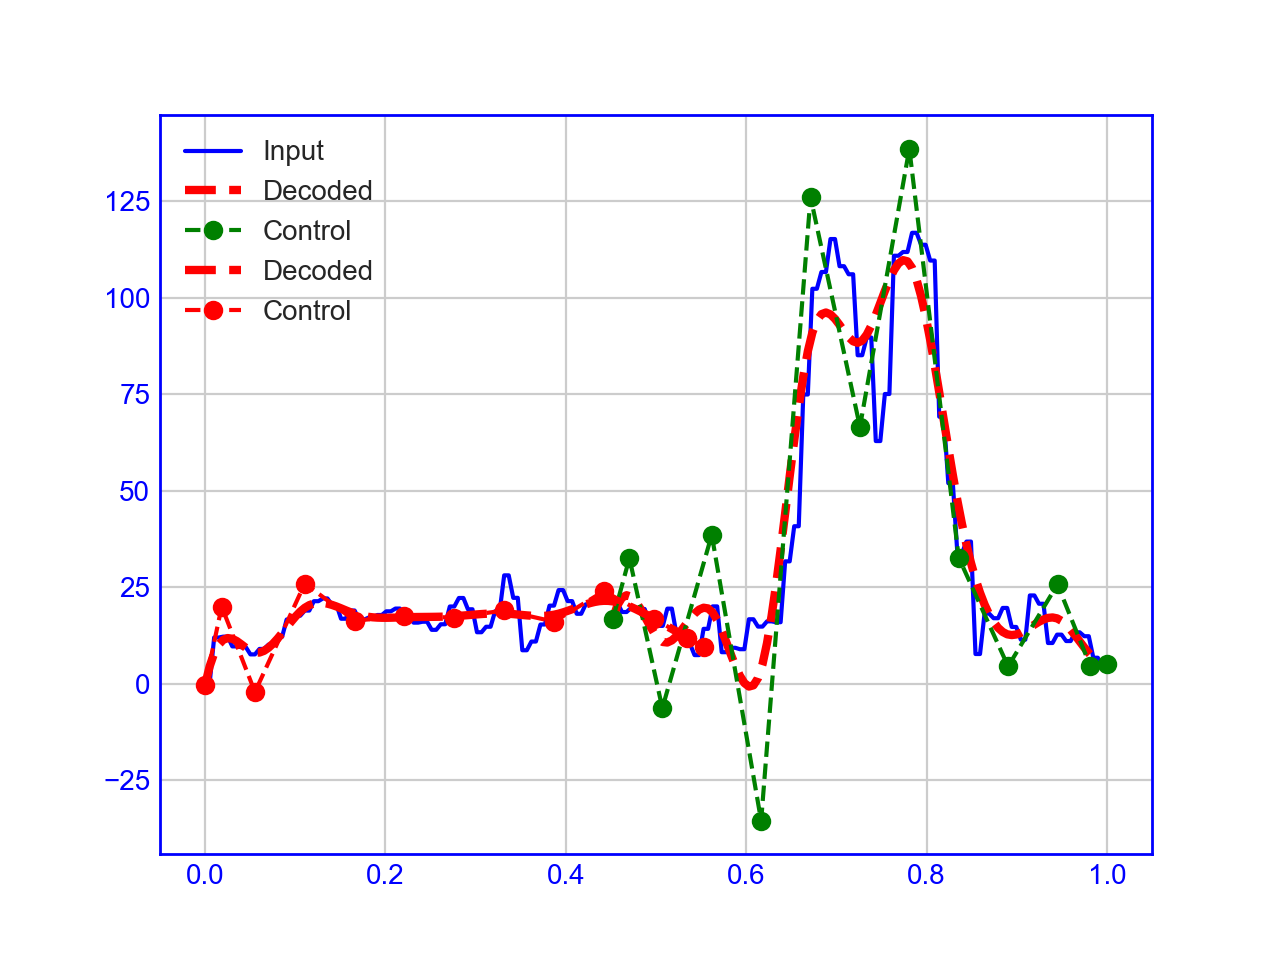

<IPython.core.display.Javascript object>


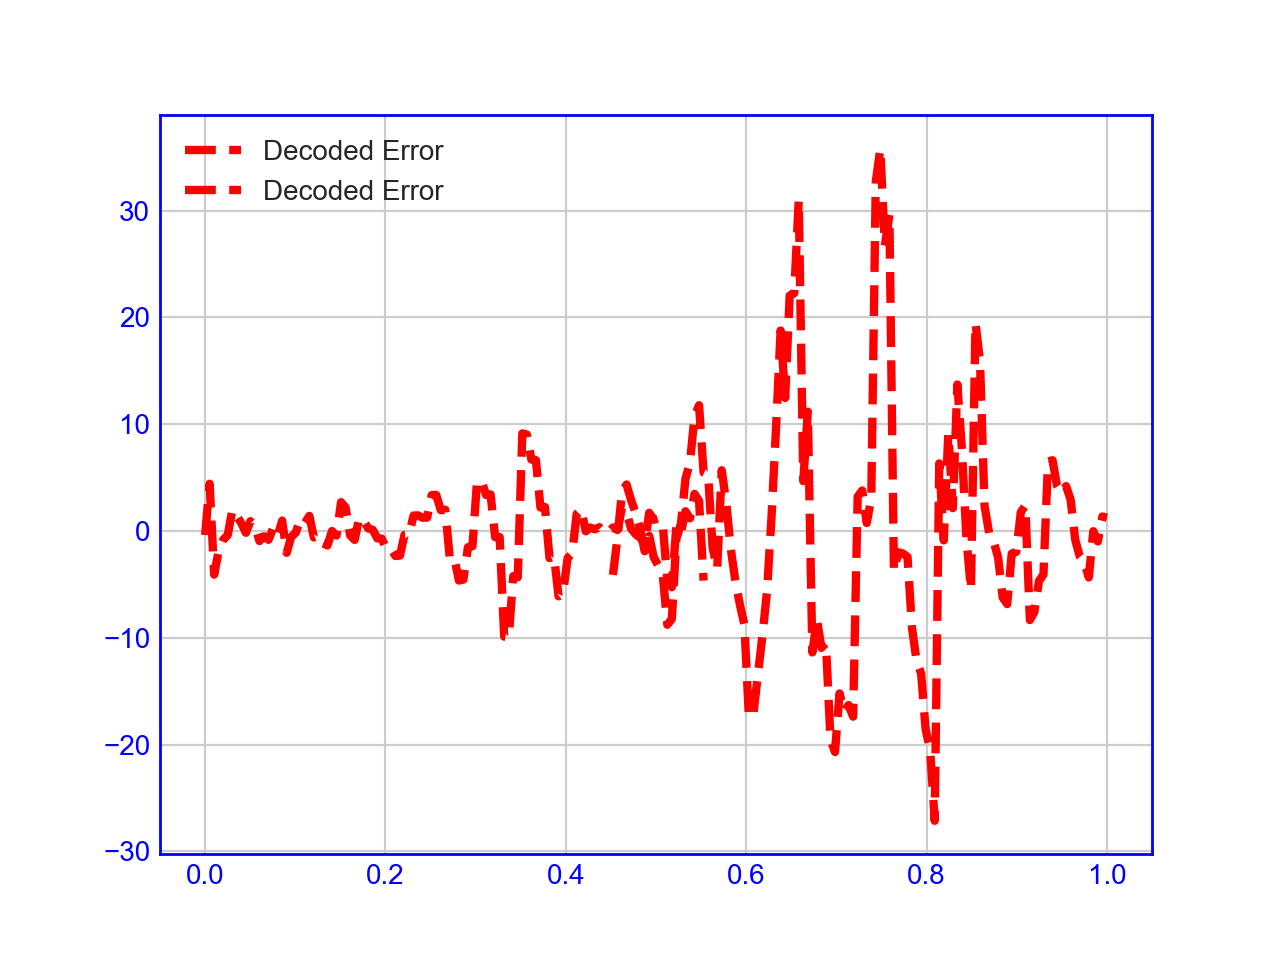


---- Starting SLSQP Iteration: 1 ----
1 sending to 0: [16.85223278]
0 sending to 1: [9.54110402]
1 received from 0: [9.54110402]
0 received from 1: [16.85223278]
Computed:  0.45226130653266333 1.0  - potential  0.45226130653266333 1.0
Subdomain --  1  Knots:  [0.45226131 0.45226131 0.45226131 0.45226131 0.50703518 0.56180905
 0.61658291 0.67135678 0.72613065 0.78090452 0.83567839 0.89045226
 0.94522613 1.         1.         1.         1.        ]
 -- Adaptive iteration:  0 : Error =  11.344950775406001
Solving the boundary-constrained LSQ problem
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.854861288061925
            Iterations: 156
            Function evaluations: 3120
            Gradient evaluations: 156
[2] : Optimization terminated successfully.
 -- Adaptive iteration:  1 : Error =  6.854861288061926
Solving the boundary-constrained LSQ problem
Optimization terminated successfully.    (Exit mode 0)
            Current function val

<IPython.core.display.Javascript object>


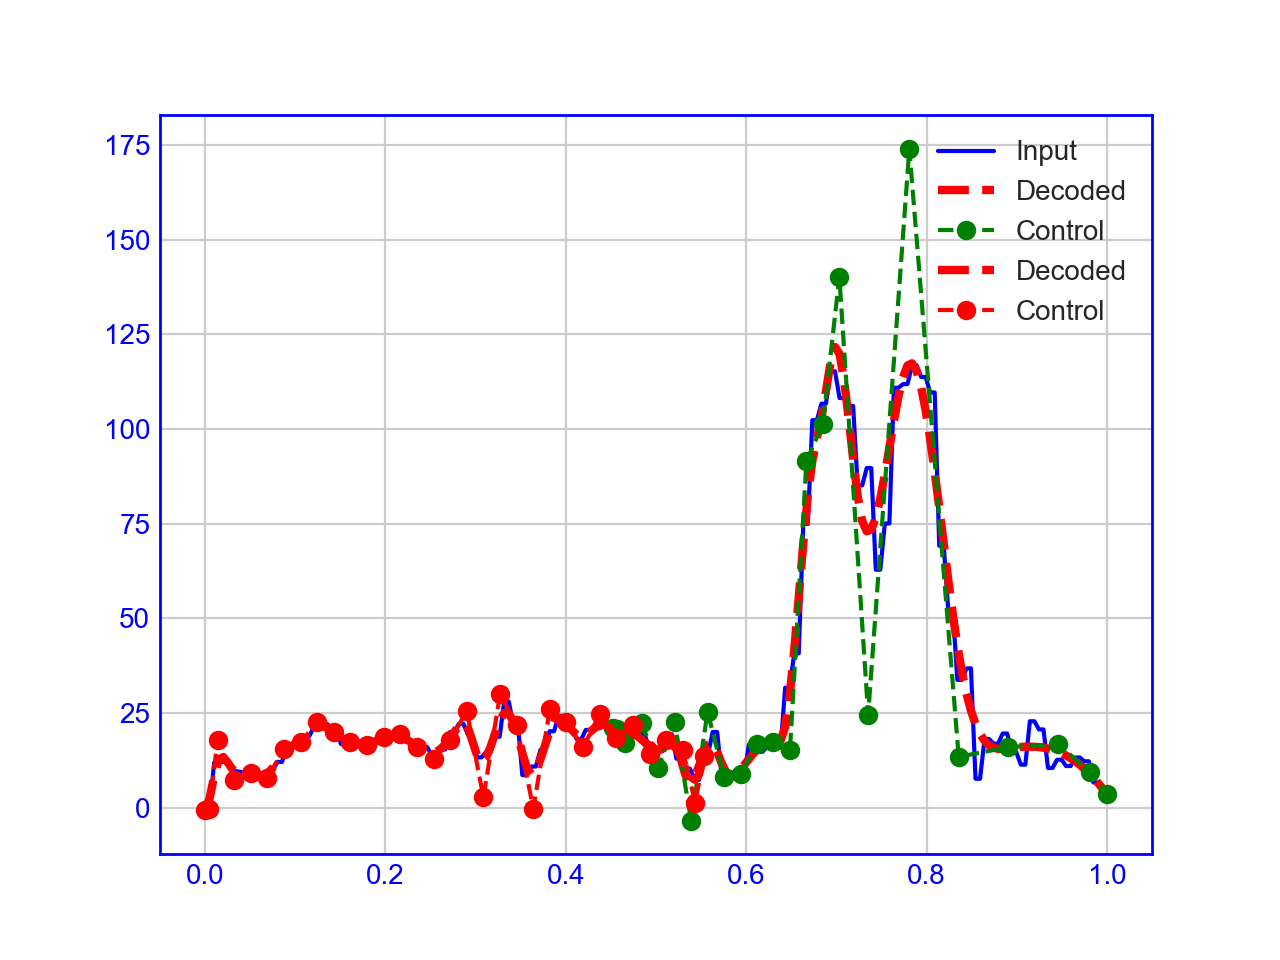

<IPython.core.display.Javascript object>


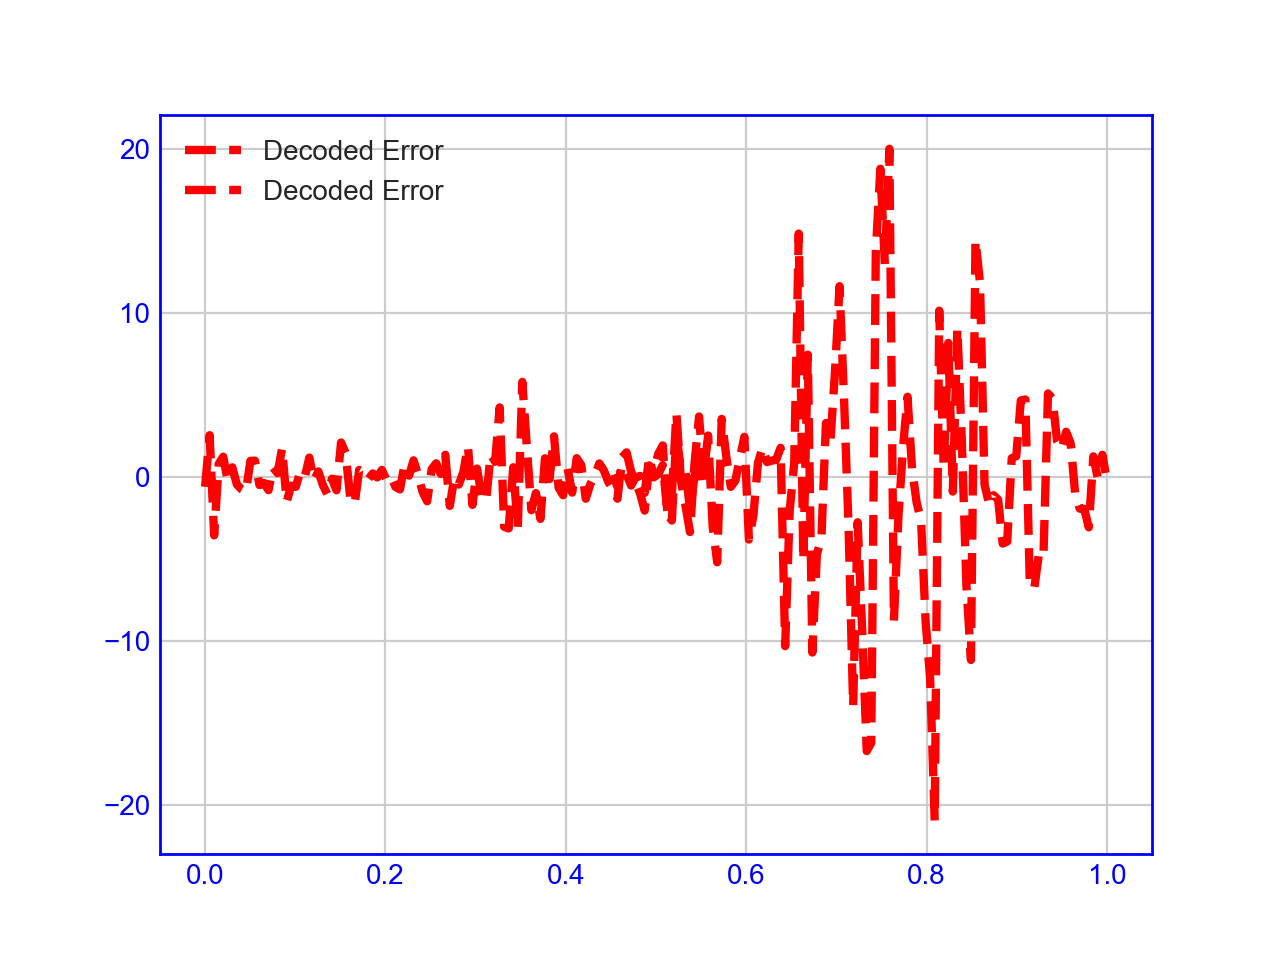


---- Starting SLSQP Iteration: 2 ----
1 sending to 0: [21.1013195]
0 sending to 1: [13.54447473]
1 received from 0: [13.54447473]
0 received from 1: [21.1013195]
Computed:  0.45226130653266333 1.0  - potential  0.45226130653266333 1.0
Subdomain --  1  Knots:  [0.45226131 0.45226131 0.45226131 0.45226131 0.46595477 0.47964824
 0.50703518 0.52072864 0.53442211 0.56180905 0.57550251 0.58919598
 0.61658291 0.63027638 0.64396985 0.67135678 0.68505025 0.69874372
 0.72613065 0.78090452 0.83567839 0.89045226 0.94522613 1.
 1.         1.         1.        ]
 -- Adaptive iteration:  0 : Error =  6.578956839573994
Solving the boundary-constrained LSQ problem
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.578956839573993
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
[2] : Optimization terminated successfully.
Subdomain:  1  -- L2 error:  6.578956839573995 , Linf error:  0.18549801101204247
Computed:

<IPython.core.display.Javascript object>


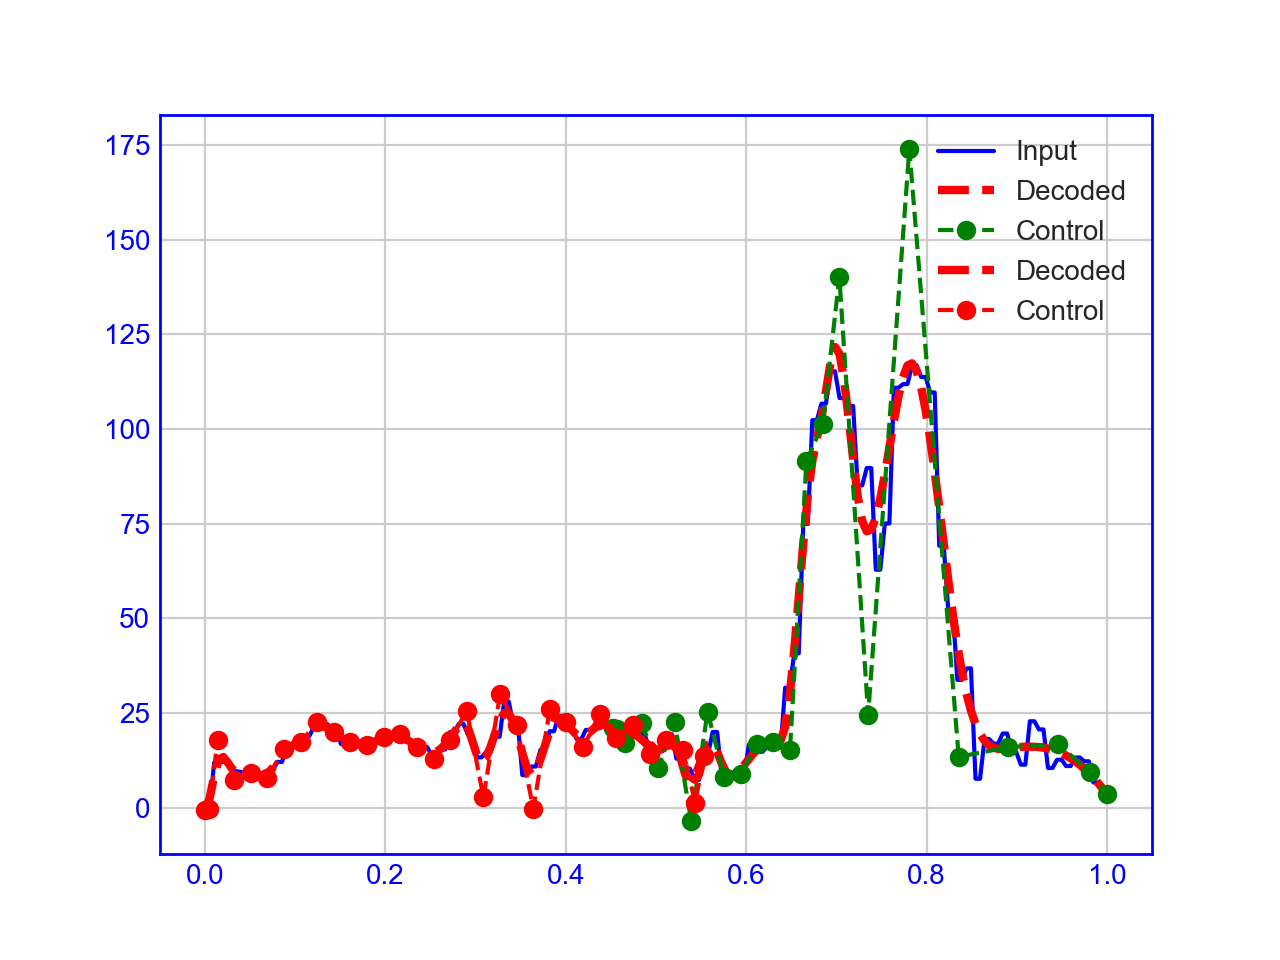

<IPython.core.display.Javascript object>


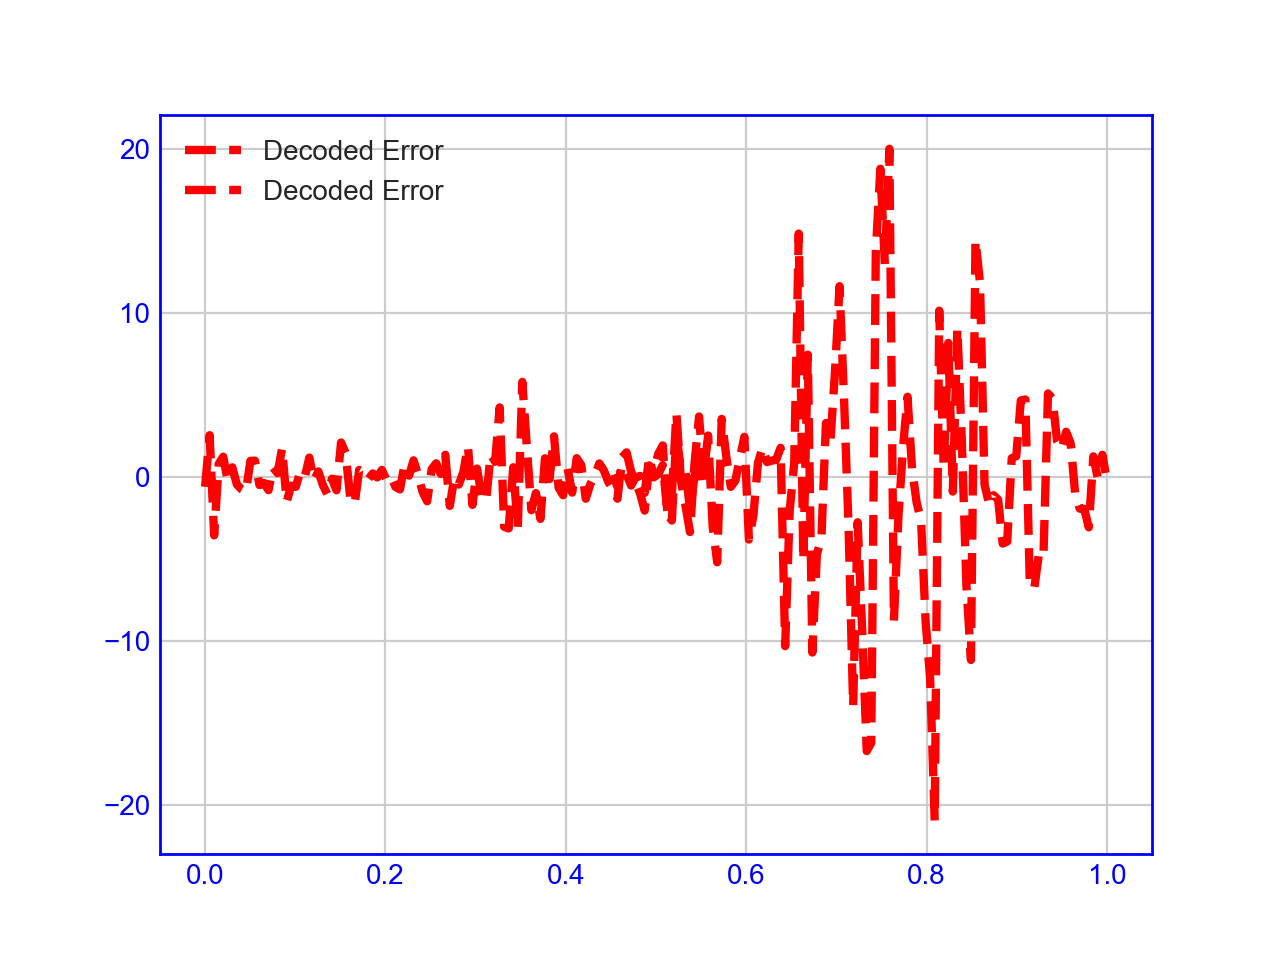


---- Starting SLSQP Iteration: 3 ----
1 sending to 0: [21.1013195]
0 sending to 1: [13.54447473]
1 received from 0: [13.54447473]
0 received from 1: [21.1013195]
Computed:  0.45226130653266333 1.0  - potential  0.45226130653266333 1.0
Subdomain --  1  Knots:  [0.45226131 0.45226131 0.45226131 0.45226131 0.46595477 0.47964824
 0.50703518 0.52072864 0.53442211 0.56180905 0.57550251 0.58919598
 0.61658291 0.63027638 0.64396985 0.67135678 0.68505025 0.69874372
 0.72613065 0.78090452 0.83567839 0.89045226 0.94522613 1.
 1.         1.         1.        ]
 -- Adaptive iteration:  0 : Error =  6.578956839573995
Solving the boundary-constrained LSQ problem
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.578956839573994
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
[2] : Optimization terminated successfully.
Subdomain:  1  -- L2 error:  6.578956839573994 , Linf error:  0.18549801101204133
Computed:

<IPython.core.display.Javascript object>


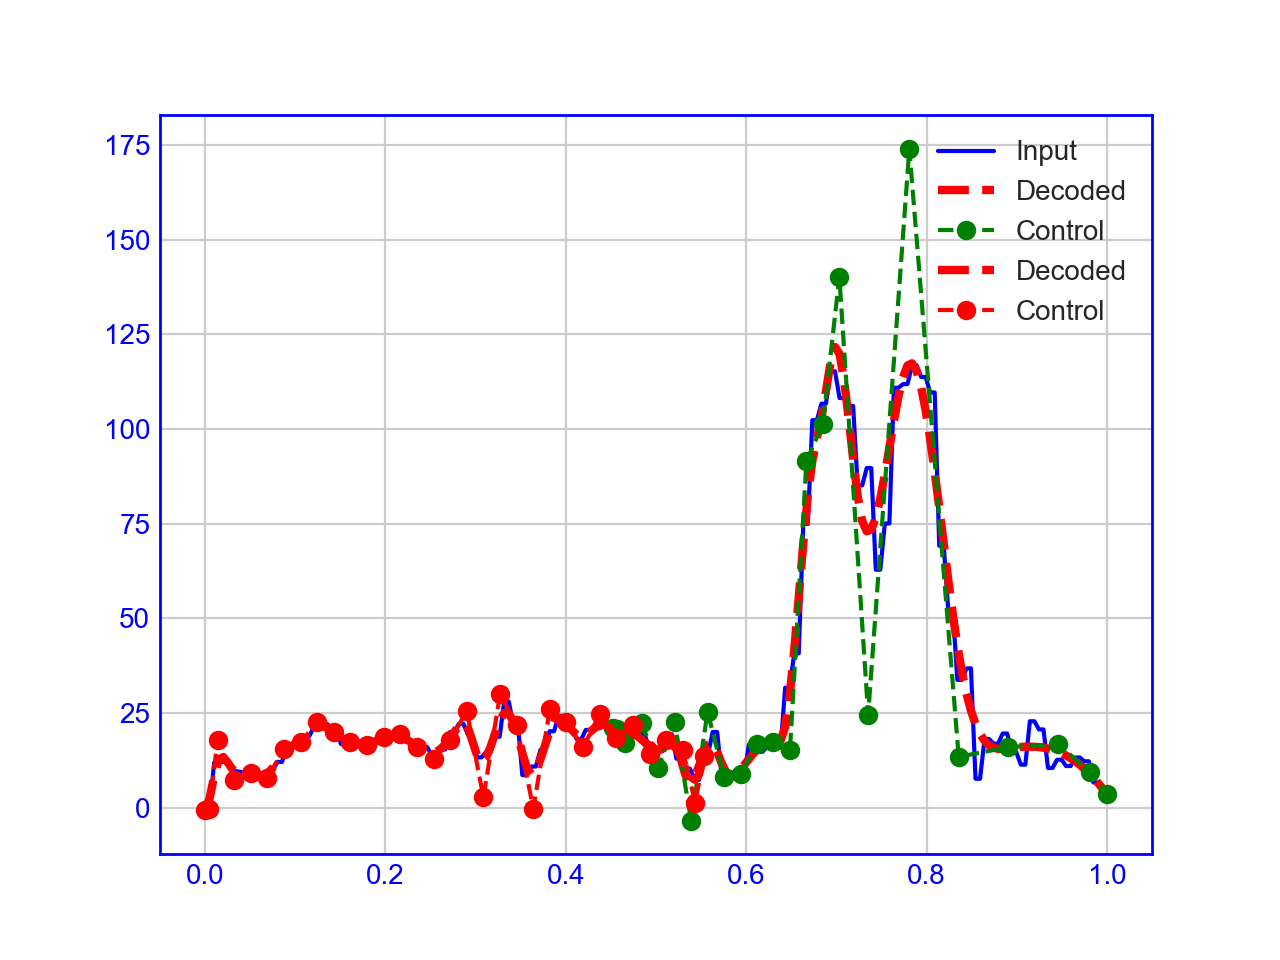

<IPython.core.display.Javascript object>


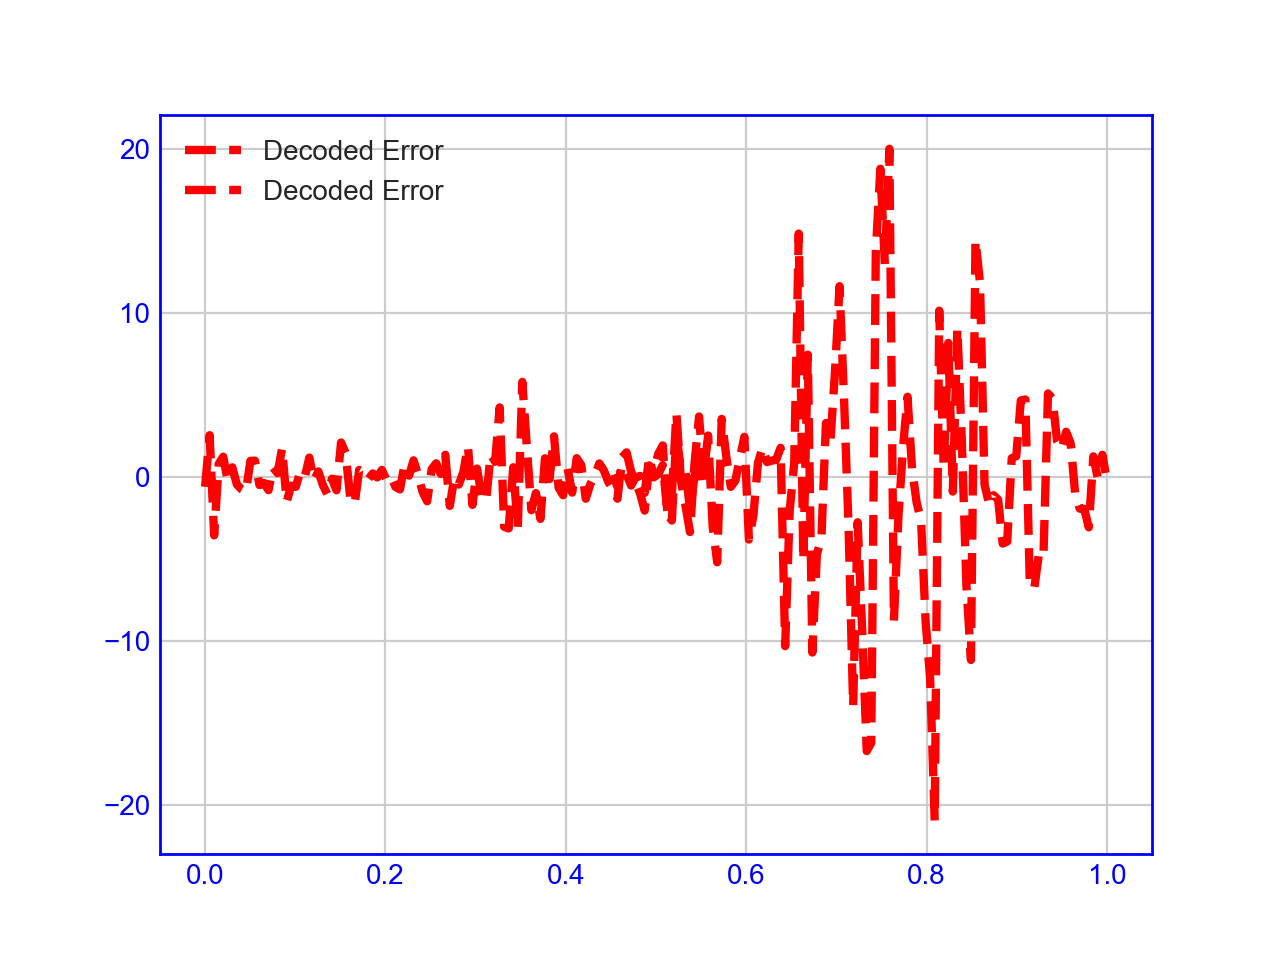


---- Starting SLSQP Iteration: 4 ----
1 sending to 0: [21.1013195]
0 sending to 1: [13.54447473]
1 received from 0: [13.54447473]
0 received from 1: [21.1013195]
Computed:  0.45226130653266333 1.0  - potential  0.45226130653266333 1.0
Subdomain --  1  Knots:  [0.45226131 0.45226131 0.45226131 0.45226131 0.46595477 0.47964824
 0.50703518 0.52072864 0.53442211 0.56180905 0.57550251 0.58919598
 0.61658291 0.63027638 0.64396985 0.67135678 0.68505025 0.69874372
 0.72613065 0.78090452 0.83567839 0.89045226 0.94522613 1.
 1.         1.         1.        ]
 -- Adaptive iteration:  0 : Error =  6.578956839573994
Solving the boundary-constrained LSQ problem
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.578956839573993
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
[2] : Optimization terminated successfully.
Subdomain:  1  -- L2 error:  6.578956839573995 , Linf error:  0.18549801101204172
Computed:

<IPython.core.display.Javascript object>


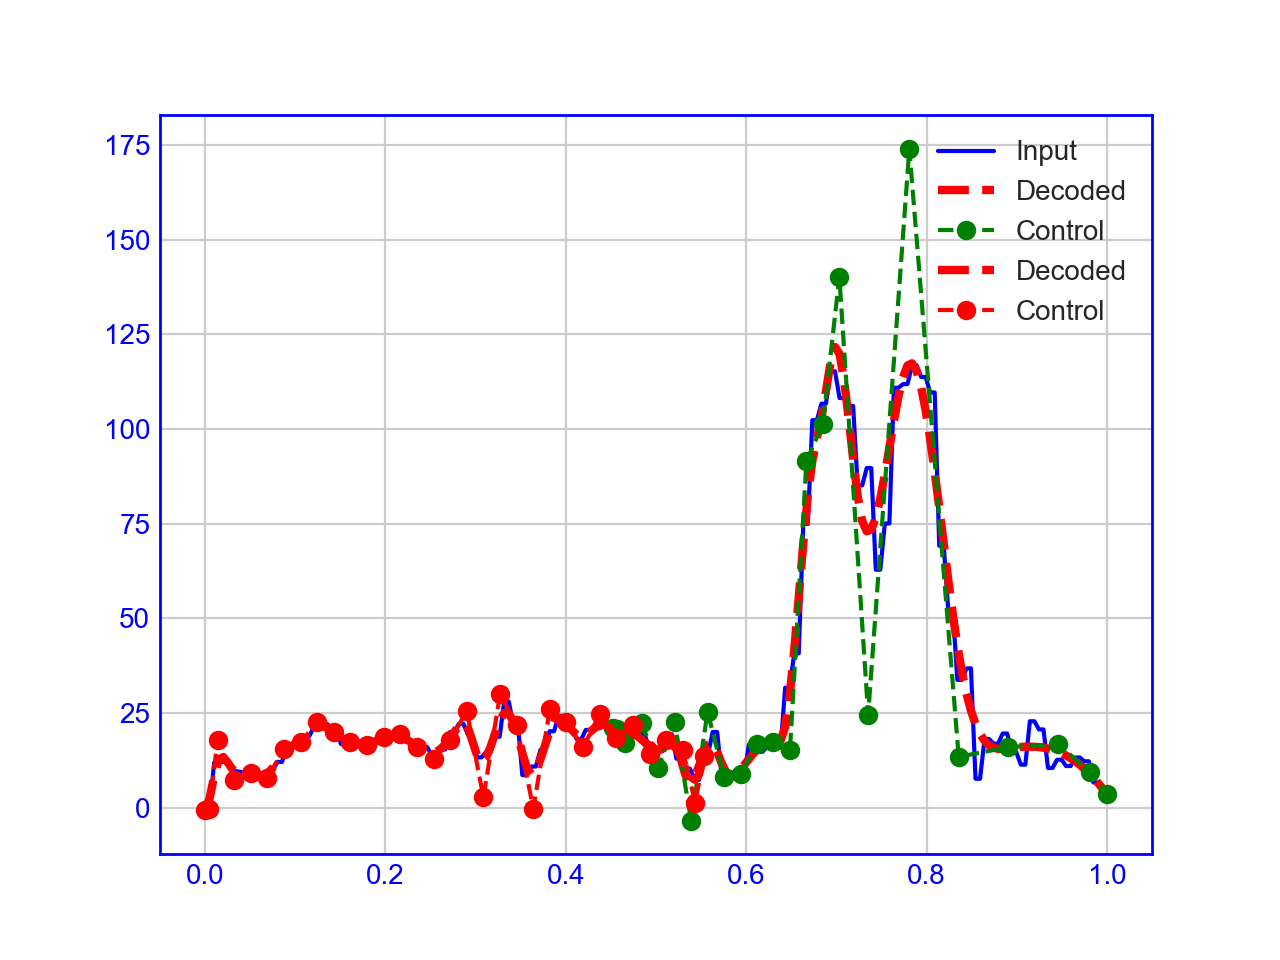

<IPython.core.display.Javascript object>


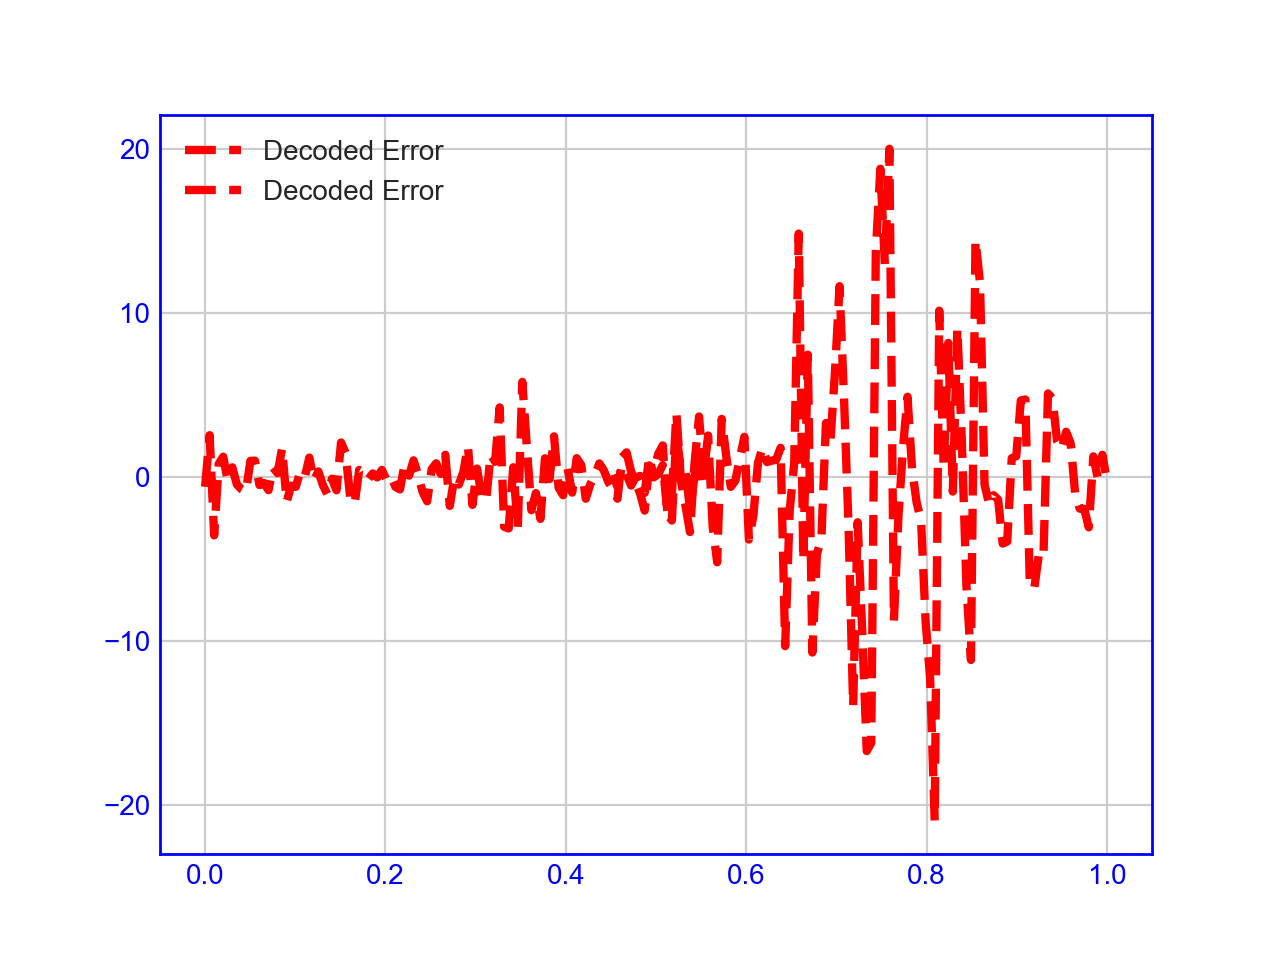


---- Starting SLSQP Iteration: 5 ----
1 sending to 0: [21.1013195]
0 sending to 1: [13.54447473]
1 received from 0: [13.54447473]
0 received from 1: [21.1013195]
Computed:  0.45226130653266333 1.0  - potential  0.45226130653266333 1.0
Subdomain --  1  Knots:  [0.45226131 0.45226131 0.45226131 0.45226131 0.46595477 0.47964824
 0.50703518 0.52072864 0.53442211 0.56180905 0.57550251 0.58919598
 0.61658291 0.63027638 0.64396985 0.67135678 0.68505025 0.69874372
 0.72613065 0.78090452 0.83567839 0.89045226 0.94522613 1.
 1.         1.         1.        ]
 -- Adaptive iteration:  0 : Error =  6.578956839573994
Solving the boundary-constrained LSQ problem
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.578956839573995
            Iterations: 1
            Function evaluations: 25
            Gradient evaluations: 1
[2] : Optimization terminated successfully.
Subdomain:  1  -- L2 error:  6.578956839573995 , Linf error:  0.18549801101204322
Computed:

<IPython.core.display.Javascript object>


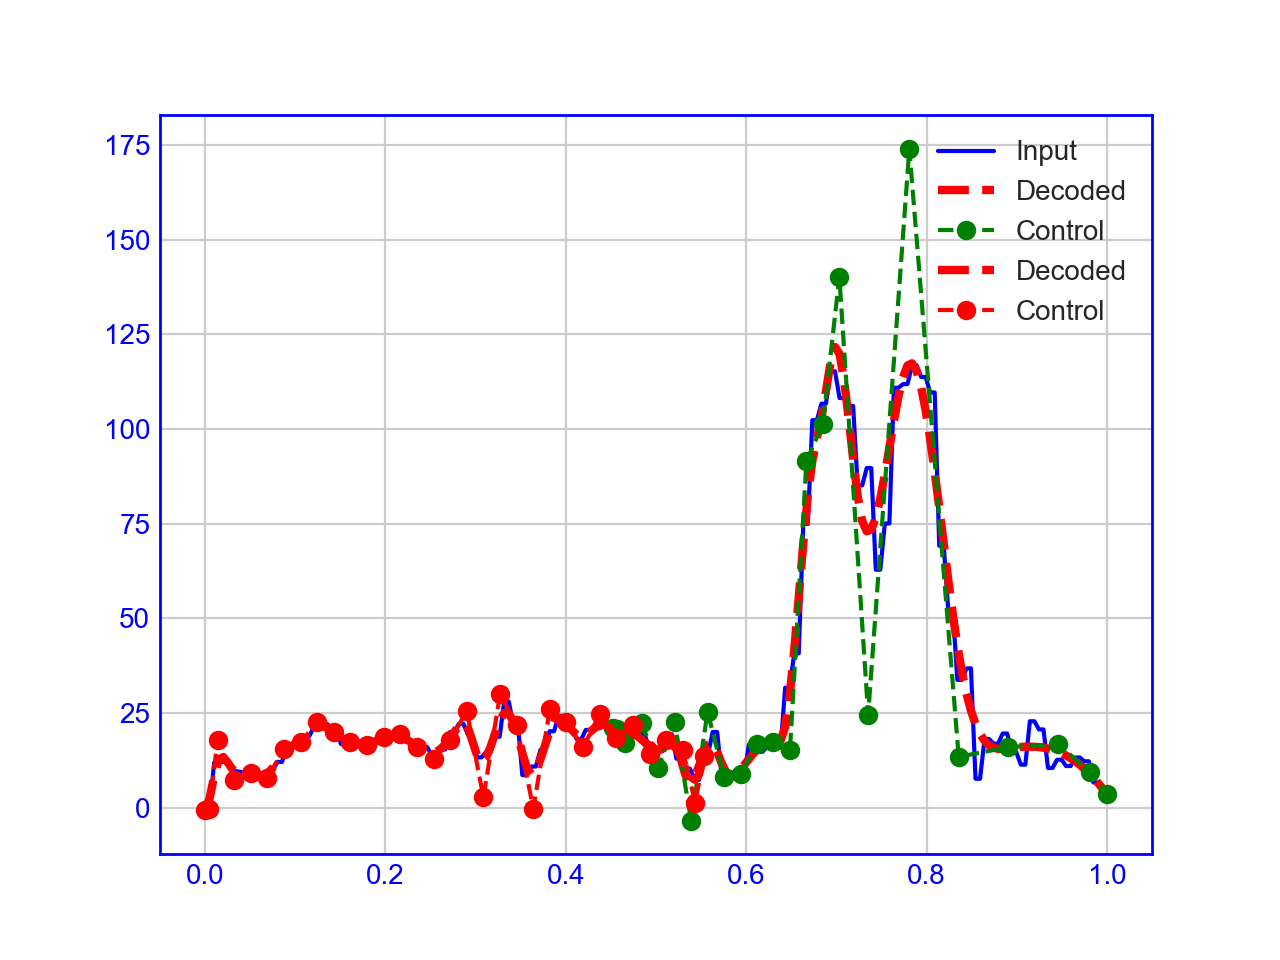

<IPython.core.display.Javascript object>


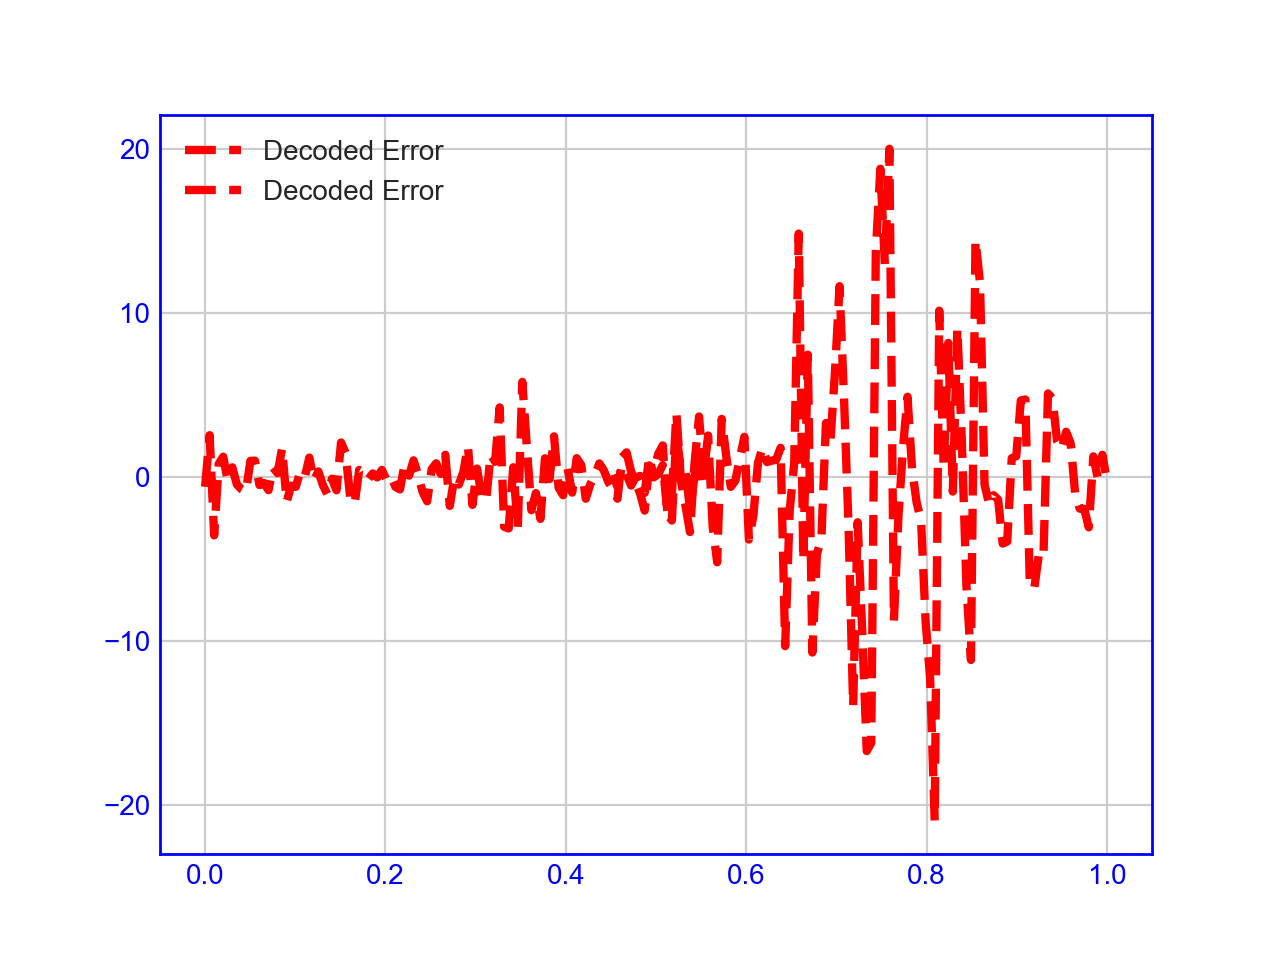

Total computational time for solve =  2.318196184000044


In [95]:
#--------------------------------------
# Let do the recursive iterations
# The variable `additiveSchwartz` controls whether we use
# Additive vs Multiplicative Schwartz scheme for DD resolution
####

class InputControlBlock:

    def __init__(self, nControlPoints, xb, xl, yl):
        self.nControlPoints = nControlPoints
        self.nControlPointSpans = nControlPoints - 1
        self.nInternalKnotSpans = self.nControlPointSpans - degree + 1
        self.nPointsPerSubD = xl.shape[0] #int(nPoints / nSubDomains) + overlapData
        self.xbounds = xb
        self.xl = xl
        self.yl = yl
        self.pAdaptive = []
        self.WAdaptive = []
        self.knotsAdaptive = []
        self.leftconstraint = np.zeros(overlapCP+1)
        self.leftconstraintKnots = np.zeros(overlapCP+1)
        self.rightconstraint = np.zeros(overlapCP+1)
        self.rightconstraintKnots = np.zeros(overlapCP+1)
        # Allocate for the constraints
        self.interface_constraints_obj = dict()
        self.interface_constraints_obj['P']=[[],[],[]]
        self.interface_constraints_obj['W']=[[],[],[]]
        self.interface_constraints_obj['T']=[[],[],[]]
        self.decodedAdaptive = np.zeros(xl.shape)

    def show(self, cp):
        print("Rank: %d, Subdomain %d: Bounds = [%d,%d]" % (w.rank, cp.gid(), self.xbounds.min[0], self.xbounds.max[0]+1))
        #cp.enqueue(diy.BlockID(1, 0), "abc")

    def plot(self, cp):
#         print(w.rank, cp.gid(), self.core)
        self.decodedAdaptive = decode(self.pAdaptive, self.WAdaptive, self.xl, 
                          self.knotsAdaptive,# * (Dmax - Dmin) + Dmin,
                          degree)
        plt.plot(self.xl, self.decodedAdaptive, 'r--', lw=3, label='Decoded')
        coeffs_x = getControlPoints(self.knotsAdaptive, degree) #* (Dmax - Dmin) + Dmin
#         print ('Coeffs-x original: ', coeffs_x)
        if nSubDomains < 5:
            plt.plot(coeffs_x, self.pAdaptive, marker='o', linestyle='--', color=['r','g','b','y','c'][cp.gid()], label='Control')
        else:
            plt.plot(coeffs_x, self.pAdaptive, marker='o', label='Control')

    def plot_error(self, cp):
#         print(w.rank, cp.gid(), self.core)
        error = self.decodedAdaptive - self.yl
        plt.plot(self.xl, error, 'r--', lw=3, label='Decoded Error')


    def plot_with_cp(self, cp, cploc, ctrlpts, lgndtitle, indx):
#         print(w.rank, cp.gid(), self.core)
        pMK = decode(ctrlpts, self.WAdaptive, self.xl, 
                          self.knotsAdaptive * (Dmax - Dmin) + Dmin, degree)
        plt.plot(self.xl, pMK, linestyle='--', color=['g','b','y','c'][indx], lw=3, label=lgndtitle)

#         if nSubDomains < 5:
#             plt.plot(cploc, ctrlpts, marker='o', linestyle='--', color=['g','b','y','c'][indx], label=lgndtitle+"_Control")
#         else:
#             plt.plot(cploc, ctrlpts, marker='o', label=lgndtitle+"_Control")

            
    def plot_with_cp_and_knots(self, cp, cploc, knots, ctrlpts, weights, lgndtitle, indx):
#         print(w.rank, cp.gid(), self.core)
        print('Plot: shapes = ', ctrlpts.shape[0], cploc.shape[0], knots.shape[0], degree)
        pMK = decode(ctrlpts, weights, self.xl, knots, degree)
        plt.plot(self.xl, pMK, linestyle='--', color=['g','b','y','c'][indx], lw=3, label=lgndtitle)

#         if nSubDomains < 5:
#             plt.plot(cploc, ctrlpts, marker='o', linestyle='--', color=['g','b','y','c'][indx], label=lgndtitle+"_Control")
#         else:
#             plt.plot(cploc, ctrlpts, marker='o', label=lgndtitle+"_Control")


#     def get_control_points(self):
#         return self.pAdaptive

#     def get_control_point_locations(self):
#         return (getControlPoints(self.knotsAdaptive, degree) * (Dmax - Dmin) + Dmin)

#     def get_knot_locations(self):
#         return self.knotsAdaptive

#     def compute_decoded_errors(self, ctrlpts):
#         domStart = 0
#         domEnd   = 1.0

#         u   = np.linspace(domStart, domEnd, self.nPointsPerSubD)
#         err = Error(ctrlpts, self.WAdaptive, self.yl, u, self.knotsAdaptive, degree)

#         return err

#     def interpolate_spline(self, xnew):
        
#         interpOrder = 'quintic' # 'linear', 'cubic', 'quintic'
#         # Interpolate using coeffs_x and control_points (self.pAdaptive)
#         coeffs_x = getControlPoints(self.knotsAdaptive, degree) * (Dmax - Dmin) + Dmin
#         #InterpCp = interp1d(coeffs_x, self.pAdaptive, kind=interpOrder)
#         InterpCp = Rbf(coeffs_x, self.pAdaptive, function=interpOrder)

#         PnewCp = InterpCp(xnew)

#         # Interpolate using xSD and pMK
#         pMK = decode(self.pAdaptive, self.WAdaptive, self.xl, 
#                       self.knotsAdaptive * (Dmax - Dmin) + Dmin, degree)
#         #InterpDec = interp1d(self.xl, pMK, kind=interpOrder)
#         InterpDec = Rbf(self.xl, pMK, function=interpOrder)
#         PnewDec = InterpDec(xnew)
        
#         return PnewCp, PnewDec


#     def interpolate(self, Pnew, xnew, tnew):

#         r = 1
#         #Pnew = self.pAdaptive[:]
#         knots = self.knotsAdaptive[:]
#         W = self.WAdaptive[:]
#         print('Original interpolation shapes: ', Pnew.shape[0], knots.shape[0])
#         # For all entries that are missing in self.knotsAdaptive, call castleDeJau 
#         # and recompute control points one by one
#         for knot in tnew:
#             #knotInd = np.searchsorted(knots, knot)
#             found = False
#             # let us do a linear search
#             for k in knots:
#                 if abs(k - knot) < 1e-10:
#                     found = True
#                     break

#             if not found:
#                 knotInd = np.searchsorted(knots, knot)
#                 if Pnew.shape[0] == knotInd:
#                     print('Knot index is same as length of control points')

#                 Pnew,W = deCasteljau(Pnew[:], W[:], knots, knot, knotInd-1, r)
#                 knots = np.insert(knots, knotInd, knot)
#                 # print('New interpolation shapes: ', Pnew.shape[0], knots.shape[0], ' after inserting ', knot, ' at ', knotInd)
        
#         cplocCtrPt = getControlPoints(knots, degree) * (Dmax - Dmin) + Dmin

#         interpOrder = 'quintic' # 'linear', 'cubic', 'quintic'
#         # Interpolate using coeffs_x and control_points (self.pAdaptive)
#         coeffs_x = getControlPoints(self.knotsAdaptive, degree) * (Dmax - Dmin) + Dmin
#         #InterpCp = interp1d(coeffs_x, self.pAdaptive, kind=interpOrder)
#         InterpCp = Rbf(coeffs_x, self.pAdaptive, function=interpOrder)

#         PnewCp = InterpCp(xnew)

#         return Pnew, PnewCp, cplocCtrPt, knots, W


    def send(self, cp):
        link = cp.link()
        for i in range(len(link)):
            target = link.target(i)
            o = np.zeros(overlapCP+1)
            if target.gid > cp.gid(): # target is to the right of current subdomain
                if len(self.pAdaptive):
                    if useDecodedResidual:
                        print('Subdomain: ', cp.gid(), self.decodedAdaptive)
#                         o = self.decodedAdaptive[-1:-2-overlapData:-1]
                        o = self.decodedAdaptive[-1-overlapData:]
                    else:
                        o = self.pAdaptive[-1-overlapCP:]
                print("%d sending to %d: %s" % (cp.gid(), target.gid, o))
            else: # target is to the left of current subdomain
                if len(self.pAdaptive):
                    if useDecodedResidual:
                        print('Subdomain: ', cp.gid(), self.decodedAdaptive)
                        o = self.decodedAdaptive[0:overlapData+1]
                    else:
                        o = self.pAdaptive[0:overlapCP+1]
                print("%d sending to %d: %s" % (cp.gid(), target.gid, o))
            cp.enqueue(target, o) 

    def recv(self, cp):
        link = cp.link()
        for i in range(len(link)):
            tgid = link.target(i).gid
            o = np.array(cp.dequeue(tgid))
            if tgid > cp.gid(): # target is to the right of current subdomain; receive constraint for right end point
                if useDecodedResidual:
                    self.rightconstraint = np.array(o[:]) if len(o) else np.zeros(overlapData+1)
                else:
                    self.rightconstraint = np.array(o[:]) if len(o) else np.zeros(overlapCP+1)
            else:
                if useDecodedResidual:
                    self.leftconstraint = np.array(o[:]) if len(o) else np.zeros(overlapData+1)
                else:
                    self.leftconstraint = np.array(o[:]) if len(o) else np.zeros(overlapCP+1)
            print("%d received from %d: %s" % (cp.gid(), tgid, o))

    def solve_adaptive(self, cp):

        ## Subdomain ID: iSubDom = cp.gid()+1
#         domStart = (cp.gid()) * 1.0 / nSubDomains
#         domEnd   = (cp.gid()+1) * 1.0 / nSubDomains
        domStart = self.xl[0]#/(Dmax-Dmin)
        domEnd   = self.xl[-1]#/(Dmax-Dmin)

        print('Computed: ', domStart, domEnd, ' - potential ', self.xl[0]/(Dmax-Dmin), self.xl[-1]/(Dmax-Dmin))

        U   = np.linspace(domStart, domEnd, self.nPointsPerSubD)

        newSolve = False
        if len(self.pAdaptive) == 0:
            newSolve = True

        if newSolve:

            inc = (domEnd - domStart) / self.nInternalKnotSpans
            knots  = np.linspace(domStart + inc, domEnd - inc, self.nInternalKnotSpans - 1)
            knots  = np.concatenate(([domStart] * (degree+1), knots, [domEnd] * (degree+1)))

#             inc = (1.0) / self.nInternalKnotSpans
#             knots  = np.linspace(inc, 1.0 - inc, self.nInternalKnotSpans - 1)
    
#             spl = LSQUnivariateSpline(U, self.yl, knots, k=degree)
#             # get the control points
#             knots    = spl.get_knots()
#             knots    = np.concatenate(([knots[0]] * degree, knots, [knots[-1]] * degree))


            popt = []
            W = []

        else:

            knots = self.knotsAdaptive[:]
            popt = self.pAdaptive[:]
            W = self.WAdaptive[:]
            nControlPoints = len(popt)

            self.nControlPointSpans = self.nControlPoints - 1
            self.nInternalKnotSpans = self.nControlPointSpans - degree + 1

        print ("Subdomain -- ", cp.gid(), ' Knots: ', knots)

        # Let do the recursive iterations
        # Use the previous MAK solver solution as initial guess; Could do something clever later
        self.interface_constraints_obj['P'][1] = popt[:]
        self.interface_constraints_obj['T'][1] = knots[:]
        self.interface_constraints_obj['W'][1] = W[:]
        
        # if there is overlapping data, project to the interface and insert the control point positions
        # as additional DoFs
        leftconstraint_projected = np.copy(self.leftconstraint)
        rightconstraint_projected = np.copy(self.rightconstraint)
        if overlapCP > 0:
            if len(self.leftconstraint) > 0:
                leftconstraint_projected, leftconstraint_projected_knots = self.interpolate(self.leftconstraint, self.leftconstraintKnots, knots)
            if len(self.rightconstraint) > 0:
                rightconstraint_projected, rightconstraint_projected_knots = self.interpolate(self.rightconstraint, self.rightconstraintKnots, knots)

        self.interface_constraints_obj['P'][0] = leftconstraint_projected[:]
        self.interface_constraints_obj['P'][2] = rightconstraint_projected[:]

        if disableAdaptivity:
            nmaxAdaptIter = 1
        else:
            nmaxAdaptIter = 2

        xSD = U * (Dmax - Dmin) + Dmin
        # Invoke the adaptive fitting routine for this subdomain
        self.pAdaptive, self.WAdaptive, self.knotsAdaptive = adaptive(cp.gid()+1, self.interface_constraints_obj, U, 
                                                                        #self.xSD, self.ySD, 
                                                                        self.xl, self.yl,
                                                                        #MAX_ERR=maxAdaptErr,
                                                                        MAX_ERR=maxAbsErr,
                                                                        split_all=True, 
                                                                        strategy=AdaptiveStrategy, 
                                                                        r=1, MAX_ITER=nmaxAdaptIter)

        # NAdaptive = basis(U[np.newaxis,:],degree,knotsAdaptive[:,np.newaxis]).T
        # E = Error(pAdaptive, WAdaptive, ySD, U, knotsAdaptive, degree)
        # print ("Sum of squared error:", np.sum(E**2))
        # print ("Normalized max error:", np.abs(E).max()/yRange)
        
        # Update the local decoded data
        self.decodedAdaptive = decode(self.pAdaptive, self.WAdaptive, self.xl, self.knotsAdaptive, degree)
        
#        print('Local decoded data for Subdomain: ', cp.gid(), self.xl.shape, self.decodedAdaptive.shape, self.xl, self.decodedAdaptive)

        errorMAK = L2LinfErrors(self.pAdaptive, self.WAdaptive, self.yl, U, self.knotsAdaptive, degree)
        print ("Subdomain: ", cp.gid(), " -- L2 error: ", errorMAK[0], ", Linf error: ", errorMAK[1])

#     return PAdaptDomain, WAdaptDomain, KnotAdaptDomains


#########
from cycler import cycler

# Routine to recursively add a block and associated data to it
def add_input_control_block(gid, core, bounds, domain, link):
    print("Subdomain %d: " % gid, core, bounds, domain, link)
    minb = bounds.min
    maxb = bounds.max
    xlocal = x[minb[0]:maxb[0]+1]
    ylocal = y[minb[0]:maxb[0]+1]
    # print("Subdomain %d: " % gid, xlocal.shape, ylocal.shape)
    mc.add(gid, InputControlBlock(nControlPoints,bounds,xlocal,ylocal), link)

# TODO: If working in parallel with MPI or DIY, do a global reduce here
showplot = True

# print "Initial condition data: ", interface_constraints
errors = np.zeros([10,1]) # Store L2, Linf errors as function of iteration

# Let us initialize DIY and setup the problem
share_face = [True]
wrap = [False]
ghosts = [overlapData]

# Initialize DIY
mc = diy.Master(w)         # master
domain_control = diy.DiscreteBounds([0], [len(x)-1])

d_control = diy.DiscreteDecomposer(1, domain_control, nSubDomains, share_face, wrap, ghosts)
a_control = diy.ContiguousAssigner(w.size, nSubDomains)

d_control.decompose(w.rank, a_control, add_input_control_block)

mc.foreach(InputControlBlock.show)

#########
import timeit
start_time = timeit.default_timer()
nmaxiter=6
for iterIdx in range(nmaxiter):

    print ("\n---- Starting %s Iteration: %d ----" % (subdomainSolver, iterIdx))
    
    # Now let us perform send-receive to get the data on the interface boundaries from 
    # adjacent nearest-neighbor subdomains
    mc.foreach(InputControlBlock.send)
    mc.exchange(False)
    mc.foreach(InputControlBlock.recv)

    if iterIdx > 1: 
        disableAdaptivity = True
    else:
        disableAdaptivity = False

    mc.foreach(InputControlBlock.solve_adaptive)

    if showplot:
        # Let us plot the initial data
        plt.figure()
        if nSubDomains > 5:
            plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y', 'c']) + cycler('linestyle', ['-','--',':','-.',''])))
        plt.plot(x, y, 'b-', ms=5, label='Input')

        mc.foreach(InputControlBlock.plot)
        plt.legend()

        plt.figure()
        mc.foreach(InputControlBlock.plot_error)
        plt.legend()

        plt.draw()

plt.show()
elapsed = timeit.default_timer() - start_time

print('Total computational time for solve = ', elapsed)

In [ ]:
overlap=1
A=np.array([4, 6, 7, 9, 12, 15, 16, 17, 20, 22, 27, 30])
indices = range(-1,-2,-1)
xa = np.array(range(-1,-3,-1))
AA = range(-1,-2-overlap,-1)
print(A)
print(A[AA])
print(A[1+overlap:-1-overlap])
print(A[-1:-2-overlap:-1])
print(A[indices])
print(xa)
ind = range(len(A)-2,len(A))
BA = np.delete(A, np.s_[ind], axis=0)
print(ind, BA)

In [ ]:
from PIL import Image as PILImage

def display_image(image_path):
    from IPython.display import Image 
    image = Image(filename=image_path)

    display(image)

def get_image(image_path):
    """Get a numpy array of an image so that one can access values[x][y]."""
    image = PILImage.open(image_path, 'r')

    width, height = image.size
    pixel_values = list(image.getdata())
    if image.mode == 'RGB':
        channels = 3
    elif image.mode == 'L':
        channels = 1
    else:
        print("Unknown mode: %s" % image.mode)
        return None
    pixel_values = np.array(pixel_values).reshape((width, height, channels))
    return image, pixel_values

image_fname = 'fish.jpg'
display_image(image_fname)
img, pvals = get_image(image_fname)

print('Shapes: ', pvals.shape)
# redVals = pvals[:,:,0]
# greenVals = pvals[:,:,1]
# blueVals = pvals[:,:,2]
# print(redVals.shape, greenVals.shape, blueVals.shape)

out = img.point(lambda i: i * 1.2)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
#plt.imshow(np.asarray(img))
plt.axis("off")
plt.imshow(img)
plt.show()

print(img)